# Forecasting energy usage from weather data - I had a lot of fun with this and so there is probably too much exploratory data analysis to get a feel for the data - but hey why not !!
# https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather


# Four years of energy and weather data are provided in 2 csv files that need to be imported. The columns of the files are list in the analysis below, productions is in mega watts MW and prices is in Euros. The weather data contains hourly observations from five cities around Spain, columns also listed below.

# The idea is to use the information provided to answer some questions, essentially to see if it is possible to forecast the hourly load forecast better than is currently done. I will use three different time series libraries to try to complete this task. The libraries are sktime (https://www.sktime.org/en/stable/), DARTS (https://unit8co.github.io/darts/) and Auto_TS (https://winedarksea.github.io/AutoTS/build/html/source/intro.html). Each of these libraries provides methods for both univariate and multivariate forecasting. Initially I looked to see if the forecast load pattern alone can be learned and then forecasted. 

# The results for this are not great (obviously) so there is a need to treat the problem as a multivariate one. I tried multiple strategies but wasn't able to use the libraries for multivariate forecasting (any hints welcome). 

# So I built a LSTM neural network after joining the datasets (I took the mean of all the observations for each city in the weather dataset for each hour) and working out the strongest correlations. The LSTM provided excellent results. As I was forecasting for the day ahead (task 3) I resampled daily (a future task would be using hourly data and then forecasting for the next 24 hours ahead). For task 4 - forecasting for the hour ahead I used all the data.

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns

from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# sktime libraries for time series forecasting

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.bats import BATS

# for imputing missing na values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [3]:
# Darts timeseries library imports

import torch # for NeuralNet NBEATS model

from darts import TimeSeries
from darts.models import (
    Prophet,
    ExponentialSmoothing,
    AutoARIMA,
    RegressionEnsembleModel,
    EnsembleModel,
    RegressionModel,
    Theta
)

from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.models import (
    #RNNModel,
    #TCNModel,
    #TransformerModel,
    NBEATSModel,
    #BlockRNNModel,
)
from darts.metrics import mape, smape, mase
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# LSTM imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# set up a scaler
from sklearn.preprocessing import MinMaxScaler

2022-05-01 19:28:27.748878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 19:28:27.748900: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# to get the plots to show in the same size
%matplotlib inline
plt.rcParams['figure.figsize'] = (25, 10)

## Import the energy dataset and weather datasets. As with the energy dataframe need to set the time to UTC to remove the issues that arise with the move into/out of daylight savings - as it is based on Madrid timezone it is only 1 hour difference to UTC.

In [5]:

# read in energy_dataset.csv and set the time column as the index
df_energy = pd.read_csv('/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv',parse_dates=['time'],index_col=['time'])

# set the date/time column dt_iso to be the index - use parse_dates to turn into datetime format but this doesn't work.
df_weather = pd.read_csv("/kaggle/input/energy-consumption-generation-prices-and-weather/weather_features.csv",parse_dates=['dt_iso'],index_col=['dt_iso'])

# The data is in the Europe/Mardid timezone which has daylight savings. This in turn makes for repeated index values at the end of each daylight savings season. To avoid this the time field needs to be converted to remove this, using UTC format will do this and allow to set the index as datetime. There is only 1 hour timezone difference so insignifcant for analysis purposes. Also remove the first value which after conversion becomes the last hour in 2014 - hence select all values form 2015 or greater.

In [6]:
# set the index as datetime type and set to UTC time - then set to correct timezone Europe/Madrid
df_energy.index = pd.to_datetime(df_energy.index, utc='True')
#df_energy.index = df_energy.index.tz_convert('Europe/Madrid')  -- can't be done or repeated values occur
# check datatype - now is a datetime 
df_energy.index

DatetimeIndex(['2014-12-31 23:00:00+00:00', '2015-01-01 00:00:00+00:00',
               '2015-01-01 01:00:00+00:00', '2015-01-01 02:00:00+00:00',
               '2015-01-01 03:00:00+00:00', '2015-01-01 04:00:00+00:00',
               '2015-01-01 05:00:00+00:00', '2015-01-01 06:00:00+00:00',
               '2015-01-01 07:00:00+00:00', '2015-01-01 08:00:00+00:00',
               ...
               '2018-12-31 13:00:00+00:00', '2018-12-31 14:00:00+00:00',
               '2018-12-31 15:00:00+00:00', '2018-12-31 16:00:00+00:00',
               '2018-12-31 17:00:00+00:00', '2018-12-31 18:00:00+00:00',
               '2018-12-31 19:00:00+00:00', '2018-12-31 20:00:00+00:00',
               '2018-12-31 21:00:00+00:00', '2018-12-31 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=35064, freq=None)

In [7]:
# use tz_localize to remove the timezone but keep the time the same 
df_energy = df_energy.tz_localize(None)
# remove the 2014 value
df_energy = df_energy[df_energy.index.year >=2015]
df_energy.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2018-12-31 13:00:00', '2018-12-31 14:00:00',
               '2018-12-31 15:00:00', '2018-12-31 16:00:00',
               '2018-12-31 17:00:00', '2018-12-31 18:00:00',
               '2018-12-31 19:00:00', '2018-12-31 20:00:00',
               '2018-12-31 21:00:00', '2018-12-31 22:00:00'],
              dtype='datetime64[ns]', name='time', length=35063, freq=None)

In [8]:
# explore the column names
df_energy.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

In [9]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35063 entries, 2015-01-01 00:00:00 to 2018-12-31 22:00:00
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35044 non-null  float64
 1   generation fossil brown coal/lignite         35045 non-null  float64
 2   generation fossil coal-derived gas           35045 non-null  float64
 3   generation fossil gas                        35045 non-null  float64
 4   generation fossil hard coal                  35045 non-null  float64
 5   generation fossil oil                        35044 non-null  float64
 6   generation fossil oil shale                  35045 non-null  float64
 7   generation fossil peat                       35045 non-null  float64
 8   generation geothermal                        35045 non-null  float64
 9   generation hydro pumped storage aggre

In [10]:
# Use panda_profiling library to investigate the data
#pandas_profiling.ProfileReport(df_energy)

# Now to clean up the datset based on the report above. Several columns can be dropped as they contain no data or are all zero. No other columns have more than 0.1% of data missing so no need to perform any further cleaning/dropping/imputation - from pandas_profile
## Empty columns are:  generation fossil coal-derived gas, generation fossil oil shale, generation fossil peat, generation geothermal, generation hydro pumped storage aggregated, generation marine, generation wind offshore, forecast wind offshore eday ahead. 

In [11]:
# drop columns
df_energy = df_energy.drop(columns=['generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 
                        'generation hydro pumped storage aggregated', 'generation marine', 'generation wind offshore', 'forecast wind offshore eday ahead'],axis=1)

In [12]:
# checking columns wered dropped - yes 8 columns dropped
df_energy.shape

(35063, 20)

In [13]:
# check for any duplicates - none so no need to drop any duplicates
df_energy.index.has_duplicates

False

# Check for na values, and if there are any use a Iterative imputer from scikit learn to replace (it is a better estimator than using the mean or median like the SimpleImputer)

In [14]:
df_energy.isna().sum()

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load forecast                             0
total load actual                              36
price day ahead                                 0
price actual                                    0


In [15]:
# now to useIterative imputer
imputer = IterativeImputer(max_iter=10, random_state=0)
imputer.fit(df_energy)
df_energy_filled = pd.DataFrame(imputer.transform(df_energy), columns = df_energy.columns, index=df_energy.index)

/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [16]:
df_energy_filled.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2018-12-31 13:00:00', '2018-12-31 14:00:00',
               '2018-12-31 15:00:00', '2018-12-31 16:00:00',
               '2018-12-31 17:00:00', '2018-12-31 18:00:00',
               '2018-12-31 19:00:00', '2018-12-31 20:00:00',
               '2018-12-31 21:00:00', '2018-12-31 22:00:00'],
              dtype='datetime64[ns]', name='time', length=35063, freq=None)

In [17]:
# check all na values have been imputed and there are no na's in the dtaframe
df_energy_filled.isna().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

In [18]:
# rename it back to df_energy
df_energy = df_energy_filled

In [19]:
# check shape again - 46 na values dropped
df_energy.shape

(35063, 20)

# Boxplot of each column to look at the spread of data and check for outliers - no obvious outliers so read to use the df_energy dataframe.

# Looks like the biggest sources of energy are fossil gas, wind onshore, nuclear, hydro reservoir and solar

<AxesSubplot:>

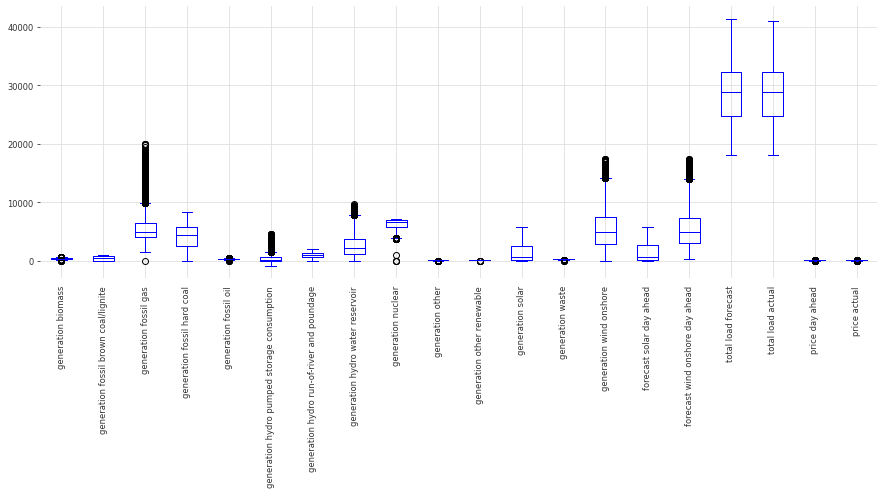

In [20]:
# boxplots of each column with labels at 90 for eas of reading
df_energy.boxplot(rot='90', color="blue",figsize=(15,5))

# Add another column to 'total generation' as sum of all the types of energy generated.

In [21]:
df_energy['total generation'] = df_energy['generation fossil gas']+df_energy['generation fossil hard coal']+df_energy['generation nuclear']+df_energy['generation wind onshore']+\
                                df_energy['generation other']+df_energy['generation other renewable']+df_energy['generation waste']+df_energy['generation hydro water reservoir']+\
                                df_energy['generation hydro pumped storage consumption']+df_energy['generation hydro run-of-river and poundage']+df_energy['generation solar']



# Plots of Generation type versus date - visualising the generation amounts by type.

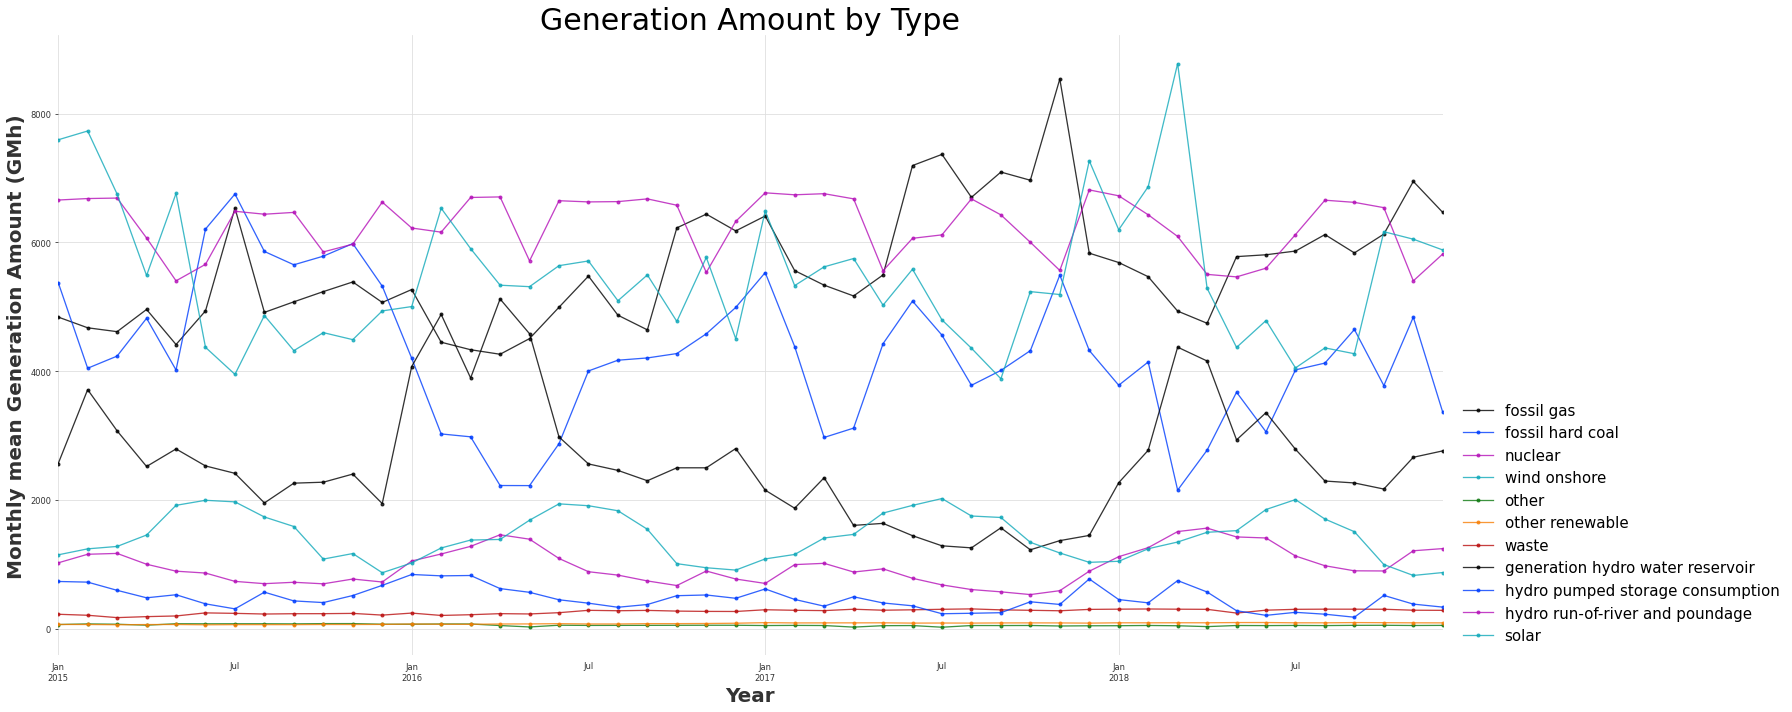

In [22]:
#axes = df_energy['total generation'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='total')
axes = df_energy['generation fossil gas'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='fossil gas')
axes = df_energy['generation fossil hard coal'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='fossil hard coal')
axes = df_energy['generation nuclear'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='nuclear')
axes = df_energy['generation wind onshore'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='wind onshore')


axes = df_energy['generation other'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='other')
axes = df_energy['generation other renewable'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='other renewable')
axes = df_energy['generation waste'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='waste')
axes = df_energy['generation hydro water reservoir'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='generation hydro water reservoir')
axes = df_energy['generation hydro pumped storage consumption'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='hydro pumped storage consumption')
axes = df_energy['generation hydro run-of-river and poundage'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='hydro run-of-river and poundage')
axes = df_energy['generation solar'].resample("M").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='solar')

axes.legend(loc='upper right', frameon=False, fontsize=15)
axes.set_title('Generation Amount by Type', fontsize=30)
axes.set_ylabel('Monthly mean Generation Amount (GMh)', fontsize=20)
axes.set_xlabel("Year", fontsize=20)
axes.legend(loc=(1.01, .01), ncol=1, fontsize=15)
plt.tight_layout()

# A better way to visualise is by percentage of total energy generated by source resampled monthly (figures are provided for every hour of the day, but give too many data points to plot nicely so resampling by month is used here)
## Interestingly no single source provides more than 30% of the total (only twice are figures above 25% ) and the 5 sources that provide at least more than 10% are nuclear, fossil hard coal, onshore wind, fossil gas and hydro water reservoir.

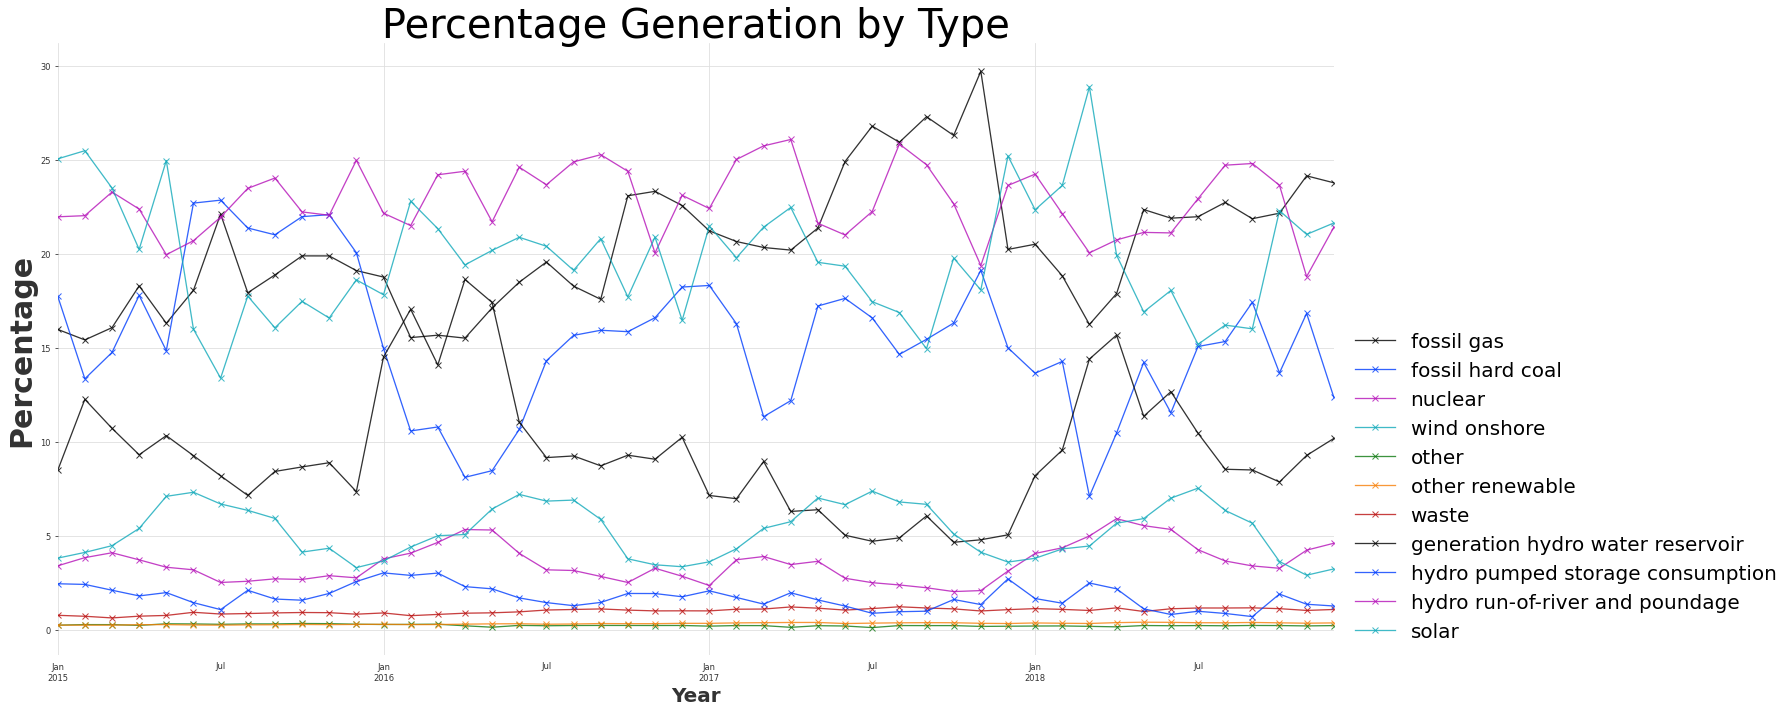

In [23]:
axes = df_energy['generation fossil gas'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='fossil gas')
axes = df_energy['generation fossil hard coal'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='fossil hard coal')
axes = df_energy['generation nuclear'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='nuclear')
axes = df_energy['generation wind onshore'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='wind onshore')


axes = df_energy['generation other'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='other')
axes = df_energy['generation other renewable'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='other renewable')
axes = df_energy['generation waste'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='waste')
axes = df_energy['generation hydro water reservoir'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='generation hydro water reservoir')
axes = df_energy['generation hydro pumped storage consumption'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='hydro pumped storage consumption')
axes = df_energy['generation hydro run-of-river and poundage'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='hydro run-of-river and poundage')
axes = df_energy['generation solar'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='solar')

axes.legend(loc='upper right', frameon=False, fontsize=15)
axes.set_title('Percentage Generation by Type', fontsize=40)
axes.set_ylabel('Percentage', fontsize=30)
axes.set_xlabel("Year", fontsize=20)
axes.legend(loc=(1.01, .01), ncol=1, fontsize=20)
plt.tight_layout()

# Total percentages of production averaged over the 4 year period 
## Some seasonality of production is evident too - solar for example peaks each July which make sense as that is summer and solar energy is stronger, the use of fossil hard coal dips each february/march (not sure why)

In [24]:
# Calculate the percentages and print out.
print('Ordered percentage of total power generated over the 4 years by each source ')
print()
print("generation nuclear                         ",round((df_energy['generation nuclear'].sum()/df_energy['total generation'].sum())*100,1),'%')
print("generation fossil gas                      ",round((df_energy['generation fossil gas'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation wind onshore                    ',round((df_energy['generation wind onshore'].sum()/df_energy['total generation'].sum())*100,1),'%')
print("generation fossil hard coal                ",round((df_energy['generation fossil hard coal'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation hydro water reservoir            ',round((df_energy['generation hydro water reservoir'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation solar                            ',round((df_energy['generation solar'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation hydro run-of-river and poundage  ',round((df_energy['generation hydro run-of-river and poundage'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation hydro pumped storage consumption ',round((df_energy['generation hydro pumped storage consumption'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation waste                            ',round((df_energy['generation waste'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation other renewable                  ',round((df_energy['generation other renewable'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation other                            ',round((df_energy['generation other'].sum()/df_energy['total generation'].sum())*100,1),'%')


Ordered percentage of total power generated over the 4 years by each source 

generation nuclear                          22.8 %
generation fossil gas                       20.4 %
generation wind onshore                     19.9 %
generation fossil hard coal                 15.5 %
generation hydro water reservoir             9.5 %
generation solar                             5.2 %
generation hydro run-of-river and poundage   3.5 %
generation hydro pumped storage consumption  1.7 %
generation waste                             1.0 %
generation other renewable                   0.3 %
generation other                             0.2 %


# Below plots show day ahead price vs actual (monthly means values) - the day ahead price is always cheaper (not always but sampled mothly it is - daily the graph is too messy) - so forecasting demand a day ahead accurately could be very useful - that is the task performed later.

Text(0, 0.5, 'Cost $')

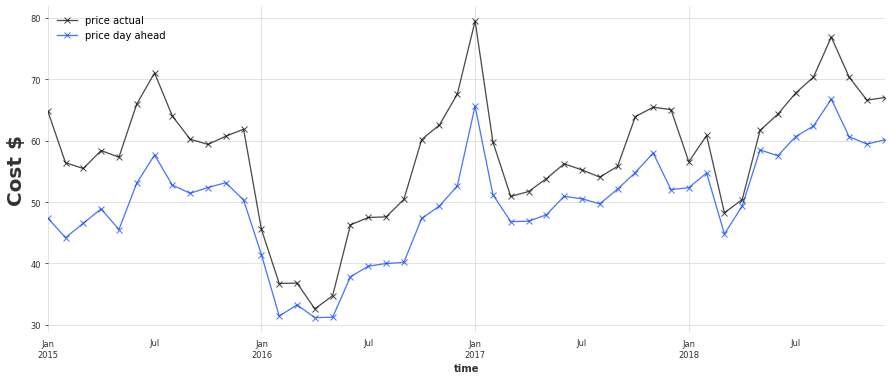

In [25]:
total_load = ['price actual','price day ahead']

group = df_energy[total_load].groupby(pd.Grouper(freq='M')).mean()
axes = group.plot(kind='line',marker='x', alpha=0.7,  figsize=(15,6))
axes.set_ylabel('Cost $', fontsize=20)


In [26]:
# price the day ahead and the actaul price averaged over the year
prices = ['price day ahead','price actual' ]
df_energy.groupby(df_energy.index.year)[prices].mean()

price day ahead  price actual
time                               
2015        50.324661     61.359949
2016        39.668449     47.438307
2017        52.233312     59.321965
2018        57.299726     63.444265

# Monthly average graph of total load forecast and actual, then monthly price forecast versus actual

## Averaged over a month the load forecast is very similar to the actual wich is a sign the forecasting is good on average over a month (the daily plot is too messy to include).

Text(0, 0.5, 'Daily Totals (GWh)')

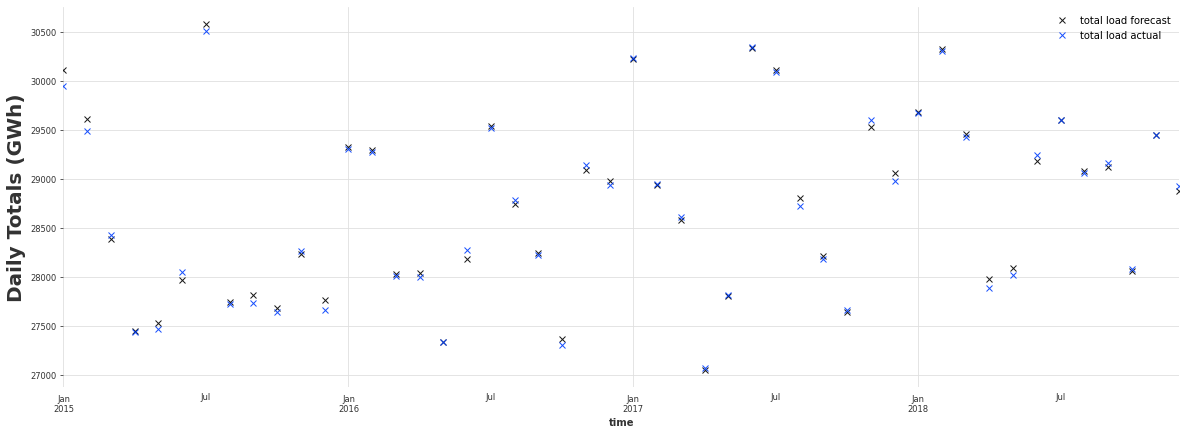

In [27]:
# load forecast vs actual - monthly resampled - change freq='M' in pd.grouper to freq='D'  to view daily resample
total_load = ['total load forecast','total load actual']

group = df_energy[total_load].groupby(pd.Grouper(freq='M')).mean()
axes = group.plot(marker='x', alpha=0.9, linestyle='None', figsize=(20,7))
axes.set_ylabel('Daily Totals (GWh)', fontsize=20)


# Now some exploratory data analysis with the weather dataset. Including doing the same thing with datetime index as with energy dataset. Including removing the first value which become a 2014 value)

In [28]:
# to show the parse dates hasn't worked so need to do explicitly in next step
print(df_weather.index.name)
print(df_weather.index.dtype)

dt_iso
object


In [29]:
# make sure the index is in datetime format.
df_weather.index = pd.to_datetime(df_weather.index, utc='True')
#df_weather.index = df_weather.index.tz_convert('Europe/Madrid') - can't do this or get repeat index values
df_weather.index

DatetimeIndex(['2014-12-31 23:00:00+00:00', '2015-01-01 00:00:00+00:00',
               '2015-01-01 01:00:00+00:00', '2015-01-01 02:00:00+00:00',
               '2015-01-01 03:00:00+00:00', '2015-01-01 04:00:00+00:00',
               '2015-01-01 05:00:00+00:00', '2015-01-01 06:00:00+00:00',
               '2015-01-01 07:00:00+00:00', '2015-01-01 08:00:00+00:00',
               ...
               '2018-12-31 13:00:00+00:00', '2018-12-31 14:00:00+00:00',
               '2018-12-31 15:00:00+00:00', '2018-12-31 16:00:00+00:00',
               '2018-12-31 17:00:00+00:00', '2018-12-31 18:00:00+00:00',
               '2018-12-31 19:00:00+00:00', '2018-12-31 20:00:00+00:00',
               '2018-12-31 21:00:00+00:00', '2018-12-31 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='dt_iso', length=178396, freq=None)

In [30]:
# use tz_localize to remove the timezone but keep the time the same 
df_weather = df_weather.tz_localize(None)
# remove the 1 value that becomes a 2014 value
df_weather = df_weather[df_weather.index.year >=2015]
df_weather.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2018-12-31 13:00:00', '2018-12-31 14:00:00',
               '2018-12-31 15:00:00', '2018-12-31 16:00:00',
               '2018-12-31 17:00:00', '2018-12-31 18:00:00',
               '2018-12-31 19:00:00', '2018-12-31 20:00:00',
               '2018-12-31 21:00:00', '2018-12-31 22:00:00'],
              dtype='datetime64[ns]', name='dt_iso', length=178391, freq=None)

# Checking for na values - none

In [31]:
#df_weather.index.dtype
df_weather.isna().sum()

city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

In [32]:
df_weather.columns

Index(['city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'weather_main', 'weather_description', 'weather_icon'],
      dtype='object')

# Drop the Kelvin temperatures and keep the celsius instead, Also Rain_3h is redundant given rain_1h, and full weather description and icon aren't need either

In [33]:
# drop these columns - keep temperature columns in Celsius, 
df_weather.drop(columns = [ 'rain_3h','weather_id','weather_description', 'weather_icon' ],axis=1, inplace=True)

In [34]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178391 entries, 2015-01-01 00:00:00 to 2018-12-31 22:00:00
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   city_name     178391 non-null  object 
 1   temp          178391 non-null  float64
 2   temp_min      178391 non-null  float64
 3   temp_max      178391 non-null  float64
 4   pressure      178391 non-null  int64  
 5   humidity      178391 non-null  int64  
 6   wind_speed    178391 non-null  int64  
 7   wind_deg      178391 non-null  int64  
 8   rain_1h       178391 non-null  float64
 9   snow_3h       178391 non-null  float64
 10  clouds_all    178391 non-null  int64  
 11  weather_main  178391 non-null  object 
dtypes: float64(5), int64(5), object(2)
memory usage: 17.7+ MB


In [35]:
df_weather.shape

(178391, 12)

## Finally check for duplicates

In [36]:
# check for duoplicates - yes
df_weather.index.has_duplicates

True

In [37]:
# So need to drop any duplicates
df_weather = df_weather.drop_duplicates(keep='first')

In [38]:
# check to shape to see if any duplicates were dropped - yes 178306-169774 = 8532 rows dropped or 0.05% 
df_weather.shape

(168456, 12)

In [39]:
# rows dropped as a percentage 178306-169774 = 8532 rows dropped or 5% 
((178306-169774)/169774)*100

5.025504494209949

In [40]:
# Use panda_profiling to investigate the data
#pandas_profiling.ProfileReport(df_weather)

# From the above report there is no real data missing - just need to check number of records for each city - all relatively similar ~ 35,000, so no location bias is likely.

<AxesSubplot:xlabel='city_name'>

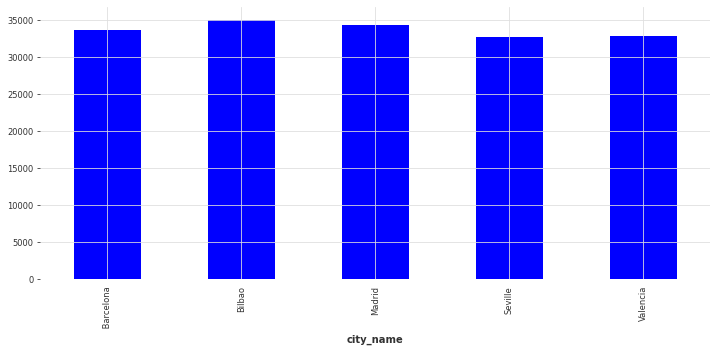

In [41]:
# As a check of number of records for each city simply check the number of temperature records and then plot.
df_weather.groupby(["city_name"])[['temp']].count().plot.bar(color="blue", legend=False, figsize=(12,5))


# So the count of values from each site is very similar (from the above bar chart). Next check for outliers and/or incorrect values.

<AxesSubplot:>

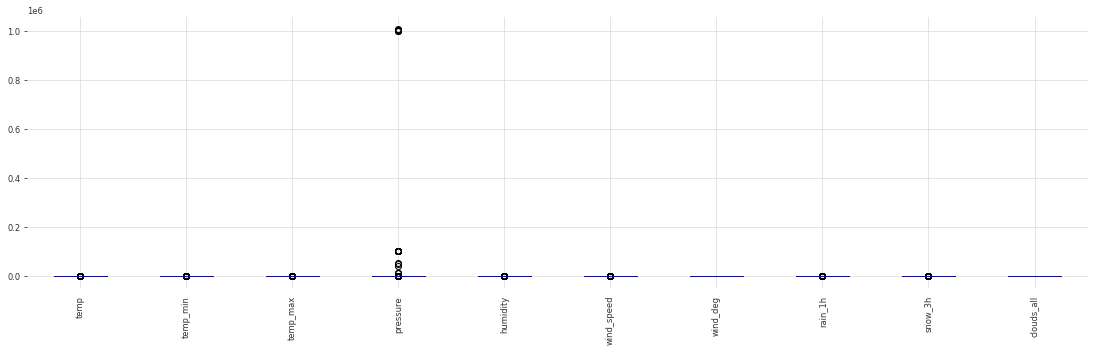

In [42]:
# boxplots for all features with labels rotated for readability. There seems to be a problem with pressure
df_weather.boxplot(rot='90', color='blue',figsize=(19, 5))

# There is definitely a problem with some pressure values. Pressure is generally measured in hectopascals hPa and actually has a tight range - definitely no less than 950 or higher that 1050. Here is a link to record values for Spanish max/min pressure - min is 950hPa, max is 1051hPa so will use these to cut off values. https://en.wikipedia.org/wiki/List_of_atmospheric_pressure_records_in_Europe#Spain  

In [43]:
# from the above there seems to be a problem with pressure
df_weather['pressure'].describe()# drop any duplicates
df_weather = df_weather.drop_duplicates(keep='first')

# So lets look at the spread and count of values less than 945 or greater than 1055 (1309 with bad pressure values)

In [44]:
sum(df_weather['pressure']<=955) + sum(df_weather['pressure']>=1051)

1228

In [45]:
# examining some records shows that the pressure is just wrong - see the pressure column.
df_weather[df_weather['pressure']>=1051]

city_name    temp  temp_min  temp_max  pressure  \
dt_iso                                                                  
2016-07-21 19:00:00    Valencia  298.94    298.71    299.26      1073   
2016-08-03 15:00:00    Valencia  308.34    302.75    312.04      1075   
2016-08-03 16:00:00    Valencia  305.31    302.75    306.48      1074   
2016-08-03 17:00:00    Valencia  304.55    302.55    305.37      1073   
2016-08-03 18:00:00    Valencia  302.94    301.65    303.71      1074   
...                         ...     ...       ...       ...       ...   
2015-02-22 09:00:00   Barcelona  283.86    283.86    283.86     10029   
2015-02-22 10:00:00   Barcelona  285.05    285.05    285.05    100304   
2015-02-22 11:00:00   Barcelona  285.45    285.45    285.45    100242   
2015-02-22 13:00:00   Barcelona  286.55    286.55    286.55    100164   
2015-10-17 01:00:00     Seville  293.51    289.15    300.15      1090   

                     humidity  wind_speed  wind_deg  rain_1h  snow_3h  \
dt_iso                                                                  
2016-07-21 19:00:00        41           3       107      0.0      0.0   
2016-08-03 15:00:00        46           1       292      0.0      0.0   
2016-08-03 16:00:00        45           1       315      0.0      0.0   
2016-08-03 17:00:00        47           0       180      0.0      0.0   
2016-08-03 18:00:00        47           1       135      0.0      0.0   
...                       ...         ...       ...      ...      ...   
2015-02-22 09:00:00         0           1        67      0.0      0.0   
2015-02-22 10:00:00         0           6        67      0.0      0.0   
2015-02-22 11:00:00         0           7       337      0.0      0.0   
2015-02-22 13:00:00         0           1         0     12.0      0.0   
2015-10-17 01:00:00        87           2        30      0.0      0.0   

                     clouds_all weather_main  
dt_iso                                        
2016-07-21 19:00:00           0        clear  
2016-08-03 15:00:00          32       clouds  
2016-08-03 16:00:00           8        clear  
2016-08-03 17:00:00          20       clouds  
2016-08-03 18:00:00          20       clouds  
...                         ...          ...  
2015-02-22 09:00:00           0        clear  
2015-02-22 10:00:00           0        clear  
2015-02-22 11:00:00           0        clear  
2015-02-22 13:00:00           0         rain  
2015-10-17 01:00:00           0        clear  

[412 rows x 12 columns]

# Based on the fact there are 169774 rows of data I will simply remove the rows with pressure errors rather than try to correct as they are ony 1309 rows out of 169774 total or 0.01% of the total.

In [46]:
# remove pressure values less than 945 and greater than 1055
df_weather = df_weather[df_weather['pressure']>= 945] 
df_weather = df_weather[df_weather['pressure']<= 1051]

In [47]:
# rows with bad pressure data removed
df_weather.shape

(167706, 12)

<AxesSubplot:>

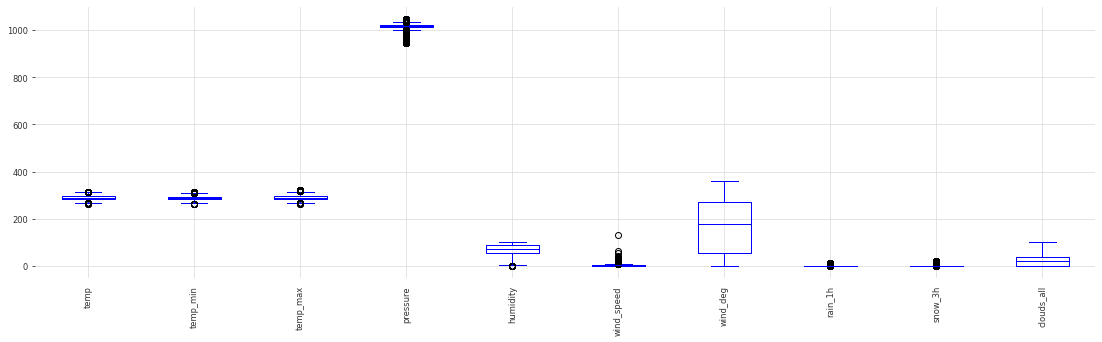

In [48]:
# boxplots for all features with labels rotated for readability.Pressue values fixed - but now wind_speed seems to have a large value
df_weather.boxplot(rot='90', color="blue",figsize=(19, 5))


<AxesSubplot:>

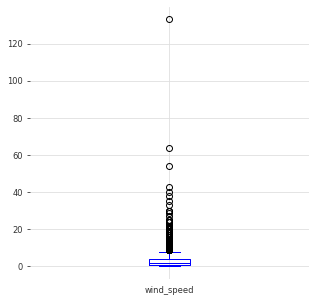

In [49]:
# checking the wind speed - max wind speed seems to be twice the next maximum and 130 km/h is a strong value
df_weather.boxplot(column='wind_speed', color="blue",figsize=(5, 5))

# Remove the windspeeds greater than 60km/h and redo boxplot - looks better now with the 134km/h and 64km/h  values removed.

<AxesSubplot:>

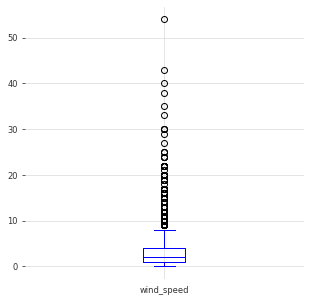

In [50]:
df_weather = df_weather[df_weather.wind_speed<=60]
df_weather.boxplot(column='wind_speed', color="blue",figsize=(5, 5))

# Last step is to convert temp, temp_min and temp_max from kelvin to celsius - simply subtract 273.15 and round to 1 decimal place and create new columns temp_C, temp_C_min, temp_C_max, then delete the temp, temp_max amd temp_min columns.

In [51]:
# convert from Kelvin to C by subtracting 273.15 and create new columns temp_C, temp_C_min, temp_C_max
df_weather['temp_C'] = round((df_weather['temp']-273.15),1)
df_weather['temp_C_max'] = round((df_weather['temp_max']-273.15),1)
df_weather['temp_C_min'] = round((df_weather['temp_min']-273.15),1)

In [52]:
df_weather.drop(columns = ['temp','temp_max','temp_min'], axis=1, inplace=True)

<AxesSubplot:>

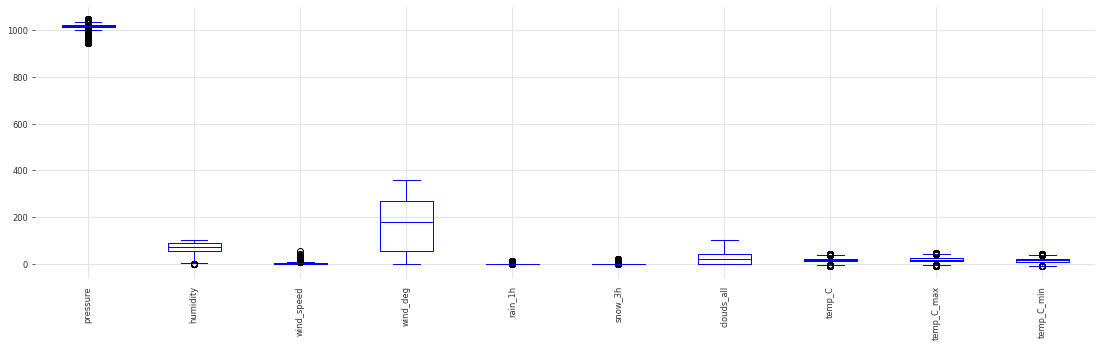

In [53]:
# boxplots for all features with labels rotated for readability.Pressue values fixed - but now wind_speed seems to have a large value
df_weather.boxplot(rot='90', color="blue",figsize=(19,5))

In [54]:
# find the names of the cities that have data
df_weather['city_name'].unique()

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

## Cities in the dataset are 'Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'

# Plotting the daily temperatures of each city. It shows the Seville (black) seems to have the highest temperatures  and Bilbao (blue) and Madrid (red) have the lowest  but the all follow the seasonal pattern.

Text(0.5, 0, 'Year')

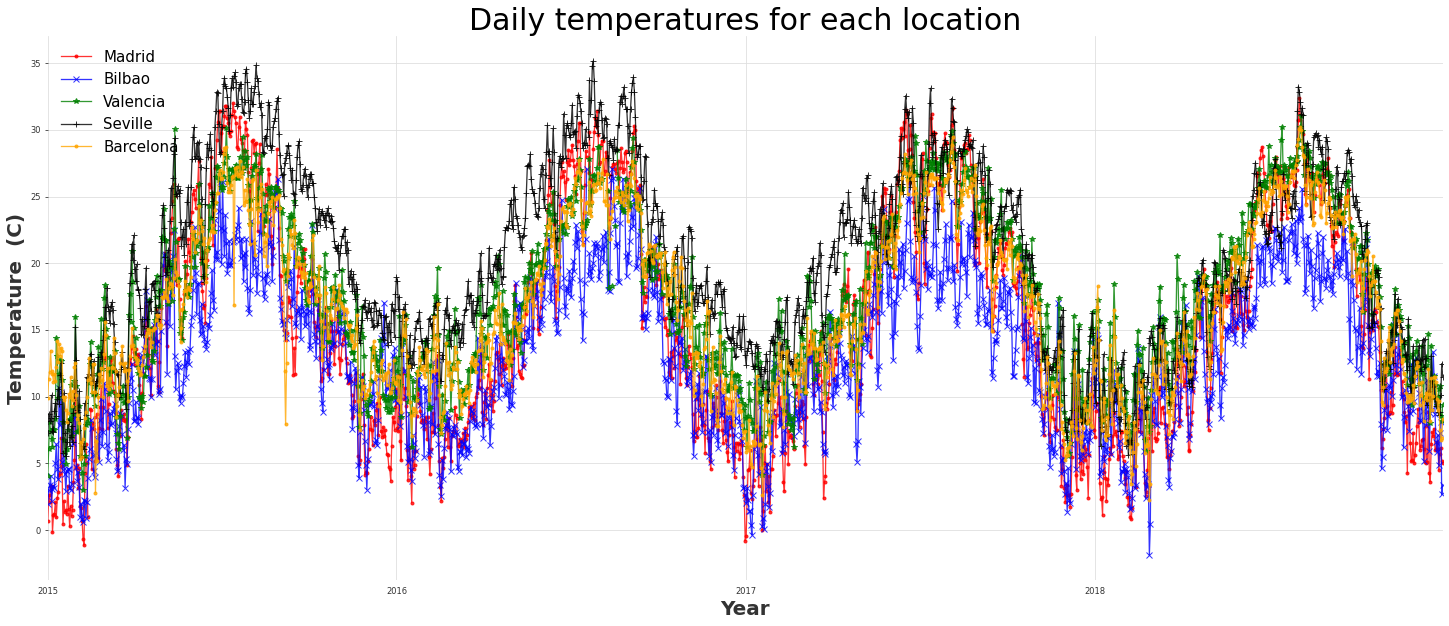

In [55]:
# Plots of daily temps for all 3 cities - to make resmpling monthly change the resample("D") to M or W for weekly
axes = df_weather[df_weather.city_name=='Madrid'    ]["temp_C"].resample("D").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='Madrid', color='red' )
axes = df_weather[df_weather.city_name=='Bilbao'    ]["temp_C"].resample("D").mean().plot(marker='x', alpha=0.8,  figsize=(25,10), label='Bilbao', color='blue')
axes = df_weather[df_weather.city_name=='Valencia'  ]["temp_C"].resample("D").mean().plot(marker='*', alpha=0.8,  figsize=(25,10), label='Valencia', color='green')
axes = df_weather[df_weather.city_name=='Seville'   ]["temp_C"].resample("D").mean().plot(marker='+', alpha=0.8,  figsize=(25,10), label='Seville', color='black')
axes = df_weather[df_weather.city_name==' Barcelona']["temp_C"].resample("D").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='Barcelona', color='orange')
axes.legend(loc='upper left', frameon=False, fontsize=15)
axes.set_title('Daily temperatures for each location', fontsize=30)
axes.set_ylabel('Temperature  (C)', fontsize=20)
axes.set_xlabel("Year", fontsize=20)

# With data imported and cleaned the questions posed can now be examine (from competition page)

## The dataset is unique because it contains hourly data for electrical consumption and the respective forecasts by the TSO for consumption and pricing. This allows prospective forecasts to be benchmarked against the current state of the art forecasts being used in industry.

### <i>   1. Visualize the load and marginal supply curves.      </i>                                                   
### <i>   2. What weather measurements, and cities influence most the electrical demand, prices, generation capacity?</i>       
### <i>   3. Can we forecast 24 hours in advance better than the TSO?</i>       
### <i>   4. Can we predict electrical price by time of day better than TSO?</i>       
### <i>   5. Forecast intraday price or electrical demand hour-by-hour.</i>       
### <i>   6. What is the next generation source to be activated on the load curve?</i>       

# ***************************************************************************************************************************

# <b>1. <i>Visualize the load and marginal supply curve - namely a scatter plot of total load versus total cost for each hourly data point - line of best fit in red</i></b>
## Through the scatter graph and the line of best fit there can be seen a gentle relationship between highter hourly demand and higher hourly prices


Text(0.5, 1.0, 'Total load versus Price')

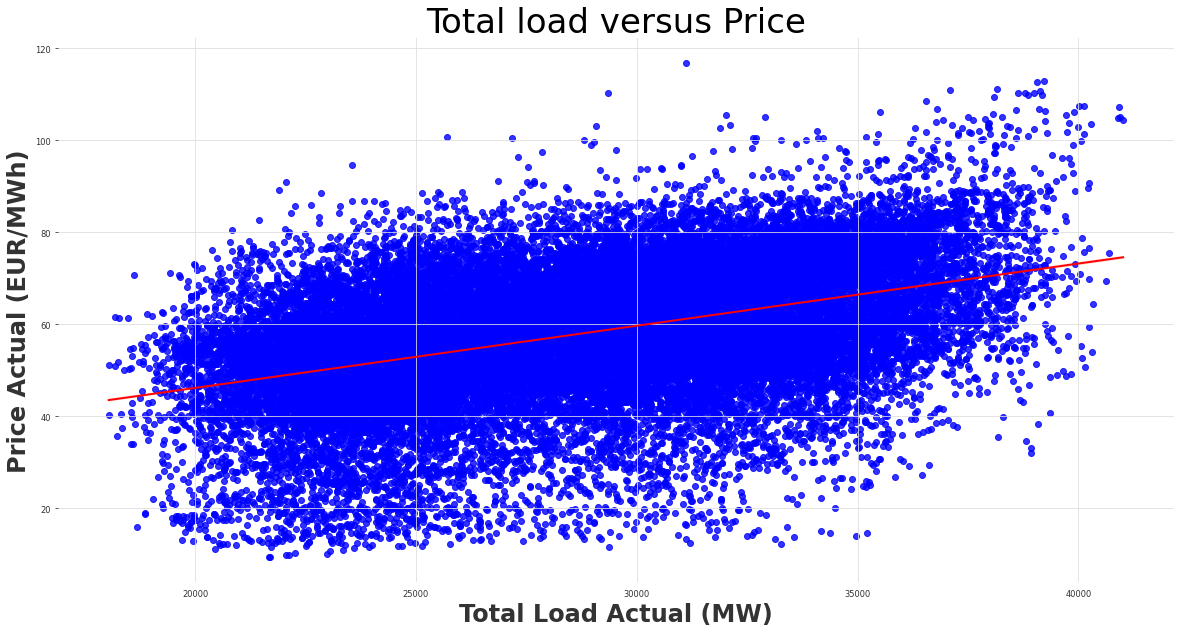

In [56]:
# plot of hours actual price vs hourly total load
plt.figure(figsize=(20,10))
# plot in blue with line of best fit in red
sns.regplot(x=df_energy['total load actual'],y=df_energy['price actual'], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.ylabel('Price Actual (EUR/MWh)', fontsize=24)
plt.xlabel('Total Load Actual (MW)', fontsize=24)
plt.title("Total load versus Price", fontsize=34)

# Next plots show the range of hourly electricity demand. There are 2 peaks in usage, the 11,12,13 hours and then again 19,20,21 hours with a minimum at 4am in the early morning. 

Text(0.5, 1.0, 'Hourly boxplots of total load')

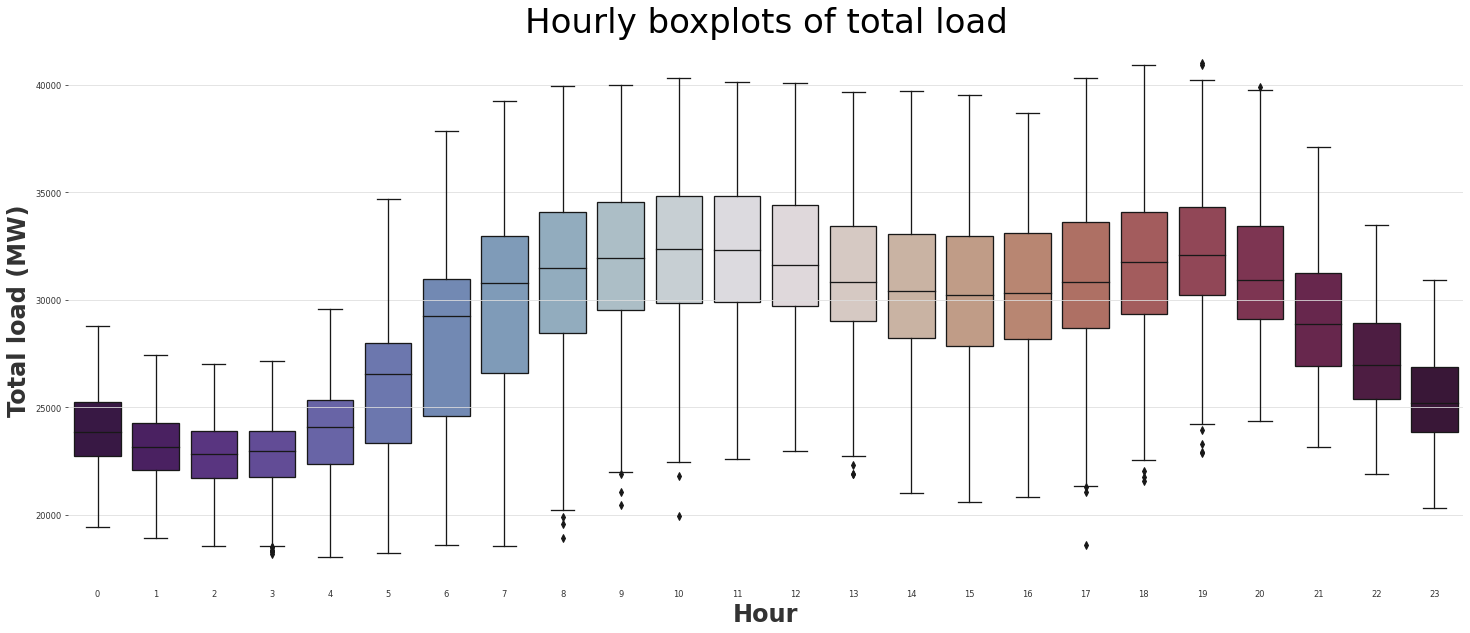

In [57]:
# Visualise by total actual load by hour

sns.boxplot(x=df_energy.index.hour, y='total load actual', data=df_energy,palette="twilight_shifted")
plt.ylabel('Total load (MW)', fontsize=24)
plt.xlabel('Hour', fontsize=24)
plt.title("Hourly boxplots of total load", fontsize=34)

# from the above graph it seems there are still some problems with outliers - will deal with later if i get the chance - future work

# Now to visualise cost per hour - not as much variation though follows the same pattern

Text(0.5, 1.0, 'Hourly boxplots of Price Actual')

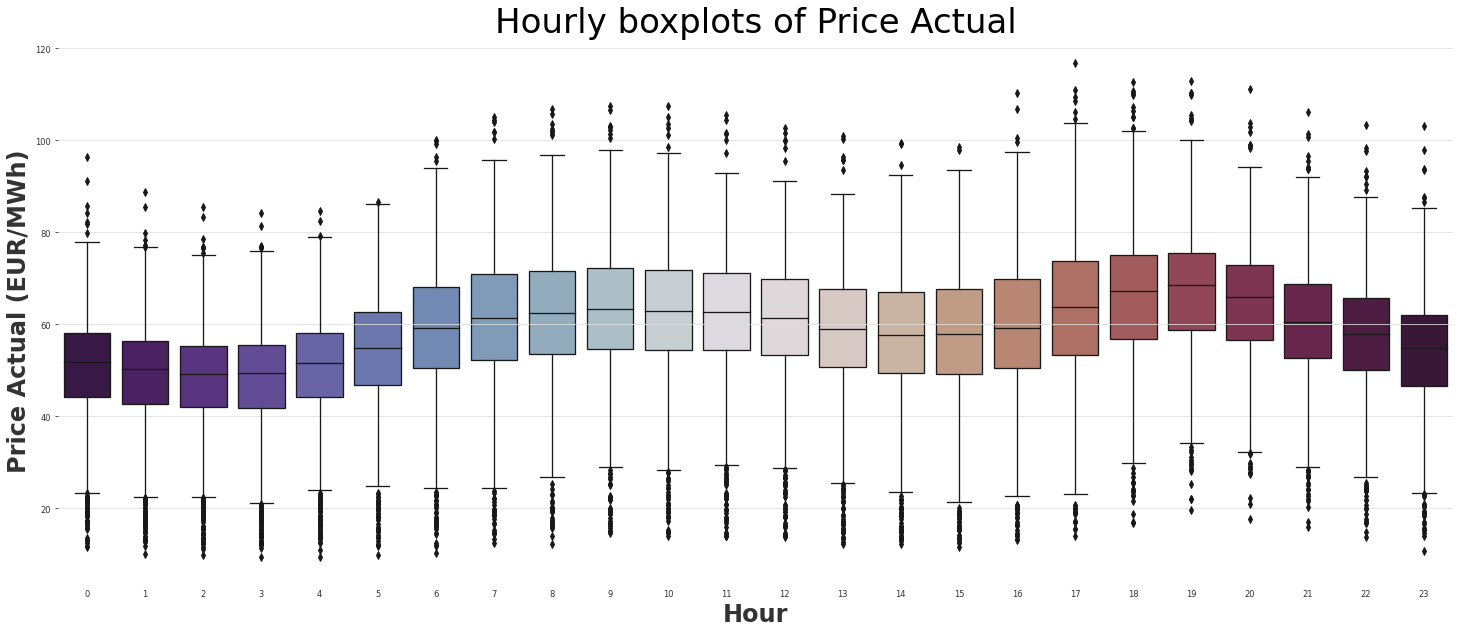

In [58]:
# Now to visualise cost by hour

sns.boxplot(x=df_energy.index.hour, y='price actual', data=df_energy,palette="twilight_shifted")
plt.ylabel('Price Actual (EUR/MWh)', fontsize=24)
plt.xlabel('Hour', fontsize=24)
plt.title("Hourly boxplots of Price Actual", fontsize=34)

# By month the greatest usage is in winter months January and February, and lowest in spring April/May and then high again in summer June/July, this links in to the idea that there is greater enery demand in either hot or cold conditions

Text(0.5, 1.0, 'Monthly boxplots of total load Actual')

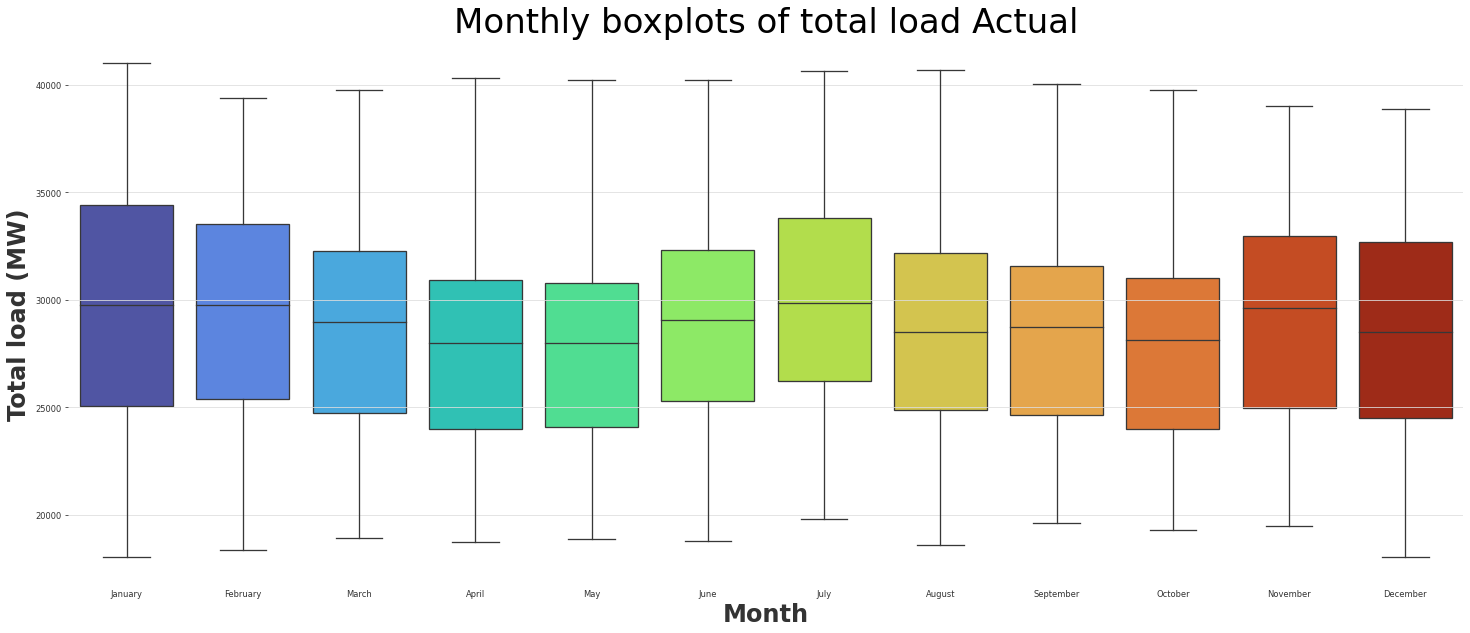

In [59]:
# Now to visualise load by month

sns.boxplot(x=df_energy.index.month_name(), y='total load actual', data=df_energy, palette="turbo")
plt.ylabel('Total load (MW) ', fontsize=24)
plt.xlabel('Month', fontsize=24)
plt.title("Monthly boxplots of total load Actual", fontsize=34)

# Another interesting view is Total Load by day of week - this matches our understanding - most days are similar with Saturday much less and Sunday the least.

Text(0.5, 1.0, 'Daily boxplots of total load actual')

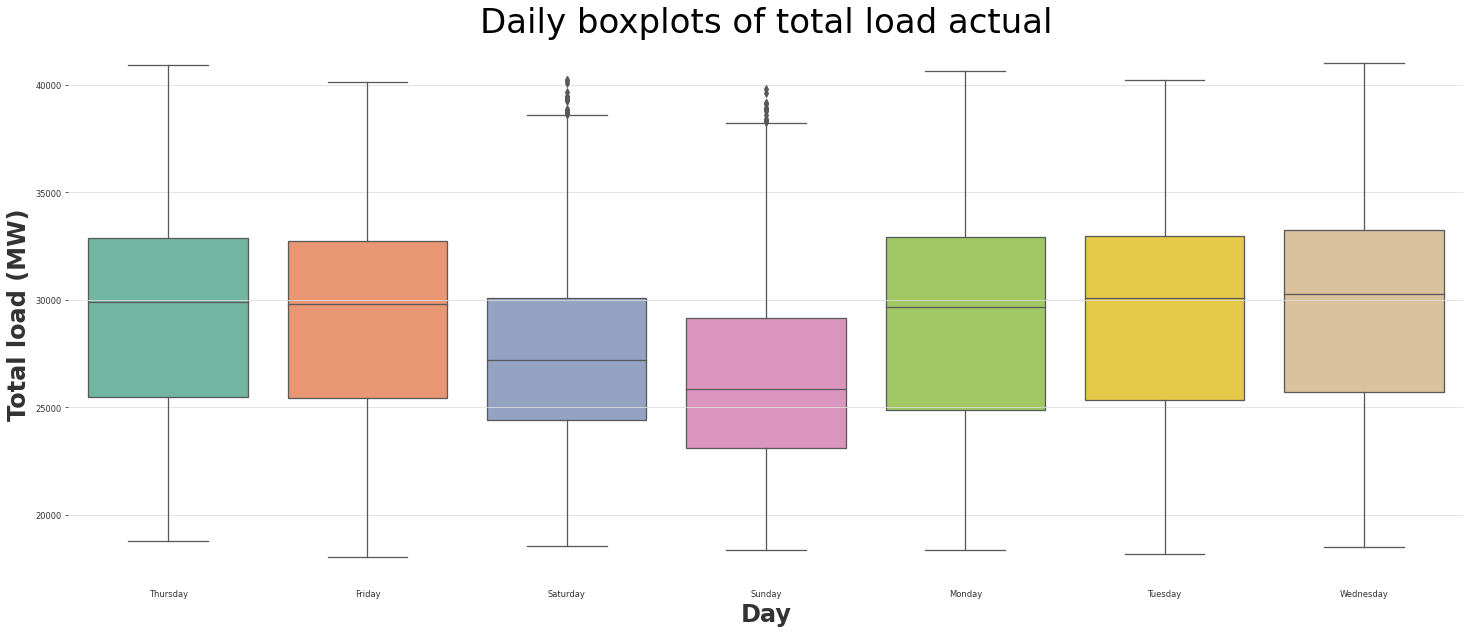

In [60]:
# Now to visualise laod by day

sns.boxplot(x=df_energy.index.day_name(), y='total load actual', data=df_energy, palette="Set2")
plt.ylabel('Total load (MW) ', fontsize=24)
plt.xlabel('Day', fontsize=24)
plt.title("Daily boxplots of total load actual", fontsize=34)

Text(0.5, 1.0, 'Daily boxplots of Total Load')

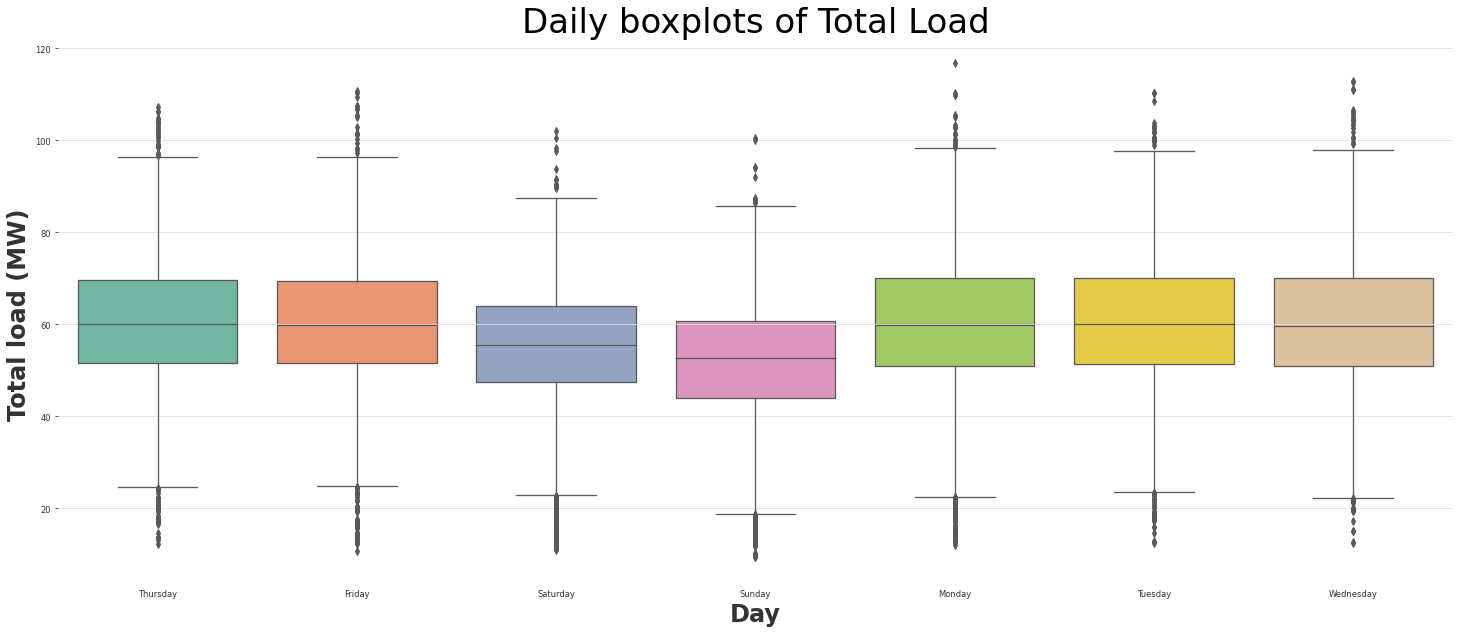

In [61]:
# Now to visualise laad by day

sns.boxplot(x=df_energy.index.day_name(), y='price actual', data=df_energy, palette="Set2")
plt.ylabel('Total load (MW) ', fontsize=24)
plt.xlabel('Day', fontsize=24)
plt.title("Daily boxplots of Total Load", fontsize=34)

Text(0.5, 1.0, 'Monthly boxplots of Price Actual')

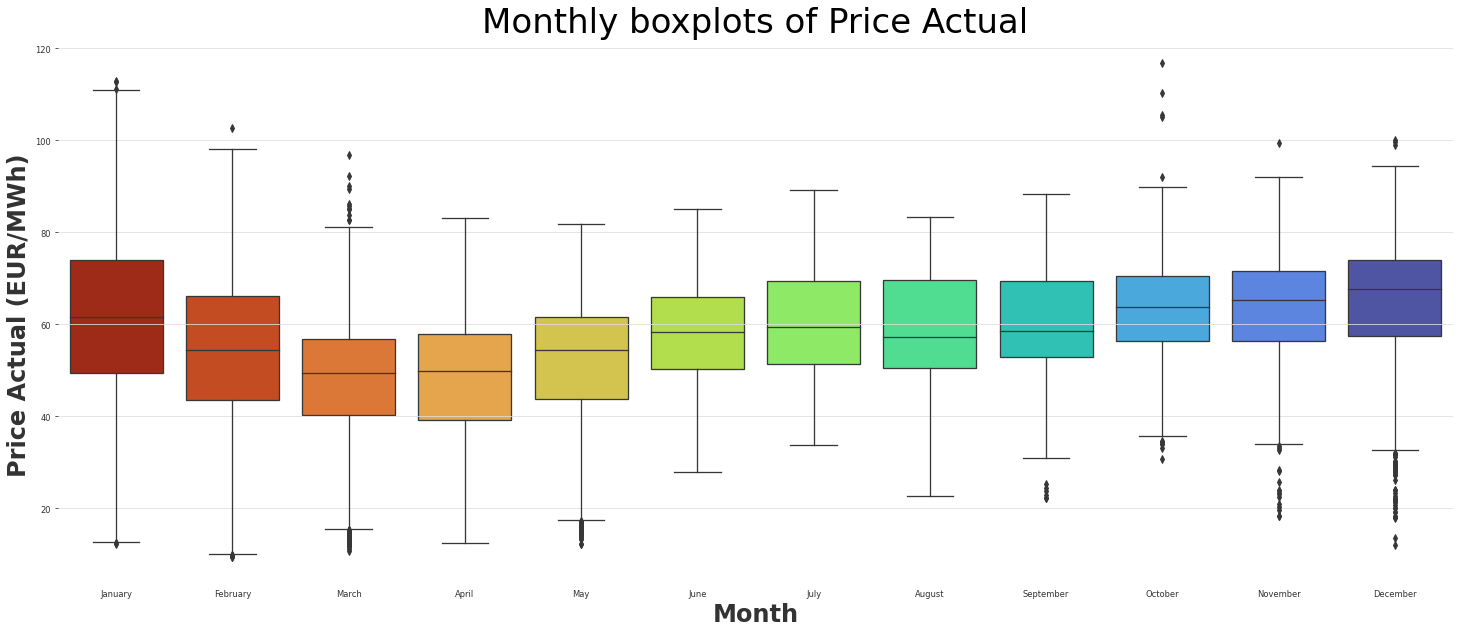

In [62]:
# Now to visualise cost by month

sns.boxplot(x=df_energy.index.month_name(), y='price actual', data=df_energy, palette="turbo_r")
plt.ylabel('Price Actual (EUR/MWh) ', fontsize=24)
plt.xlabel('Month', fontsize=24)
plt.title("Monthly boxplots of Price Actual", fontsize=34)

# <b>   2. <i>What weather measurements, and cities influence most the electrical demand, prices, generation capacity?</i></b>

## To answer this need to look at: temperatures/humidity for demand (air-conditioning/heating), cloud free days for solar generation, windiest location for wind power generation.

##  Cities in the weather dataset are : 'Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'

## Let's get max/min/mean values for temperature/humidity/wind_speed - as in the dataset exploration in the beginning, the highest mean temperature is Seville (and also the maximum temp value), the coldest is Barcelona, Madrid has the lowest humidity and they all have similar mean wind speed - first as the values, then displayed as boxplots.

In [63]:
# # group by city min/max/mean temps, humidity and wind speed
temps = ['temp_C', 'humidity','wind_speed']
df_weather.groupby(df_weather['city_name'])[temps].agg({'min','max','mean'}).round(1)

temp_C             humidity            wind_speed         
              min   max  mean      min  max  mean        min max mean
city_name                                                            
 Barcelona  -10.9  36.0  16.7        0  100  73.2          0  15  2.8
Bilbao       -6.3  39.3  13.2       11  100  79.0          0  15  2.0
Madrid       -9.0  40.2  15.1        0  100  59.1          0  18  2.4
Seville      -2.1  42.5  20.1        7  100  64.0          0  15  2.5
Valencia     -4.3  38.0  17.6        8  100  64.6          0  54  2.8

 Barcelona         AxesSubplot(0.1,0.679412;0.363636x0.220588)
Bilbao        AxesSubplot(0.536364,0.679412;0.363636x0.220588)
Madrid             AxesSubplot(0.1,0.414706;0.363636x0.220588)
Seville       AxesSubplot(0.536364,0.414706;0.363636x0.220588)
Valencia               AxesSubplot(0.1,0.15;0.363636x0.220588)
dtype: object

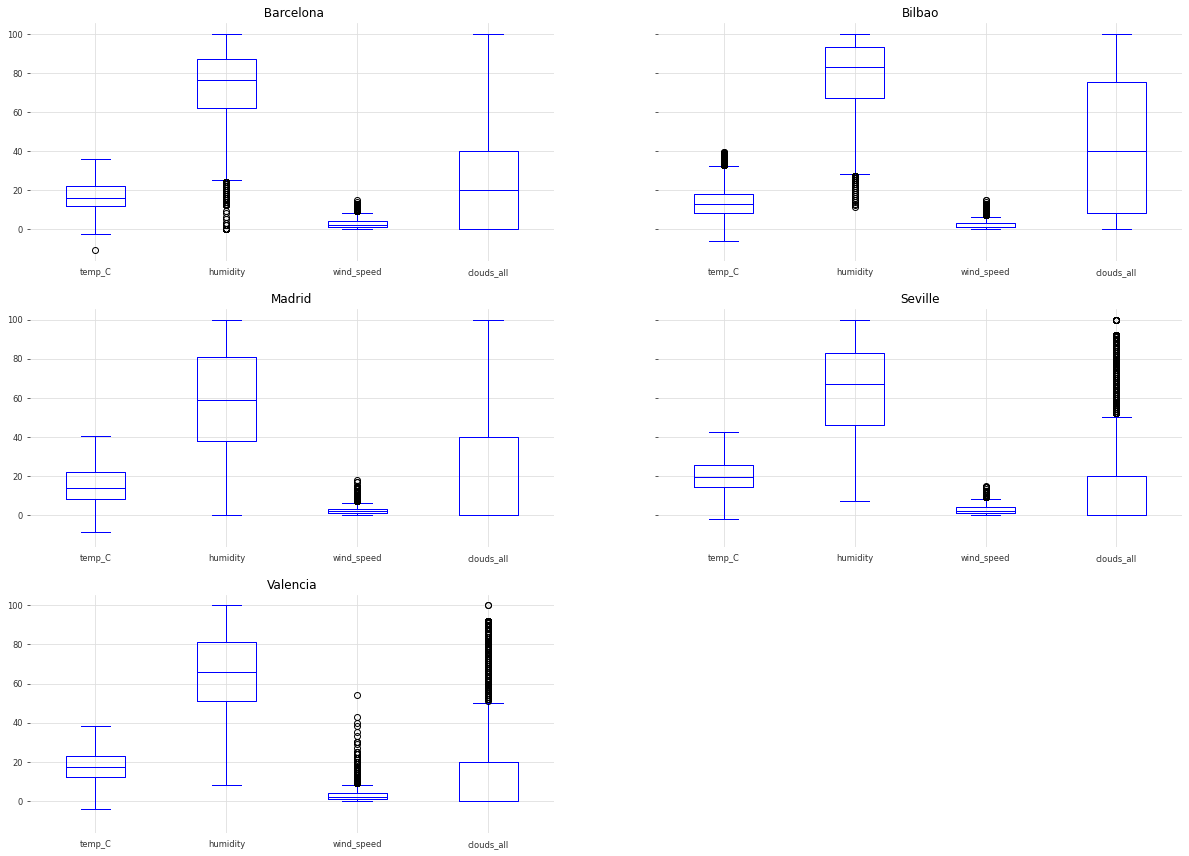

In [64]:
# # group by city mean temps and wind speed - no need to display pressure as scale id different and not that important.
temps = ['city_name','temp_C','humidity','wind_speed','clouds_all']
df_weather[temps].groupby(['city_name']).boxplot(color="blue",figsize=(20,15))

# Another way of viewing cloud data is via simple plot - the visual density would seem to suggest Bilboa is the cloudiest and Madrid/Seville the least cloudy.

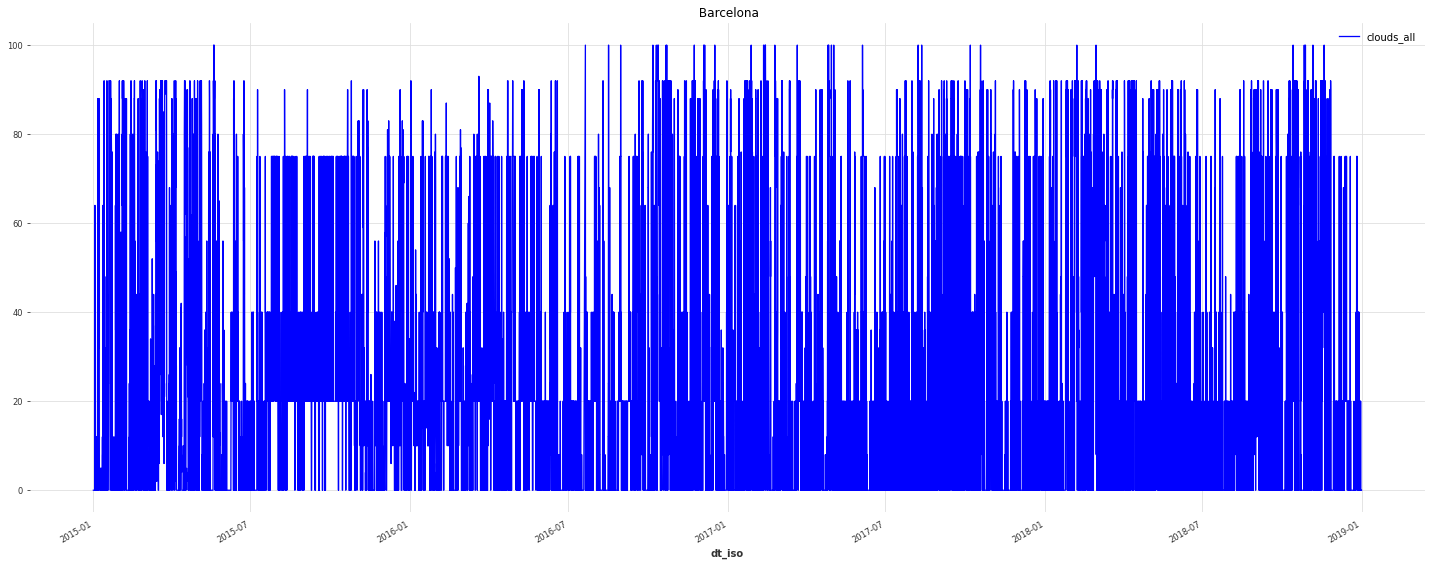

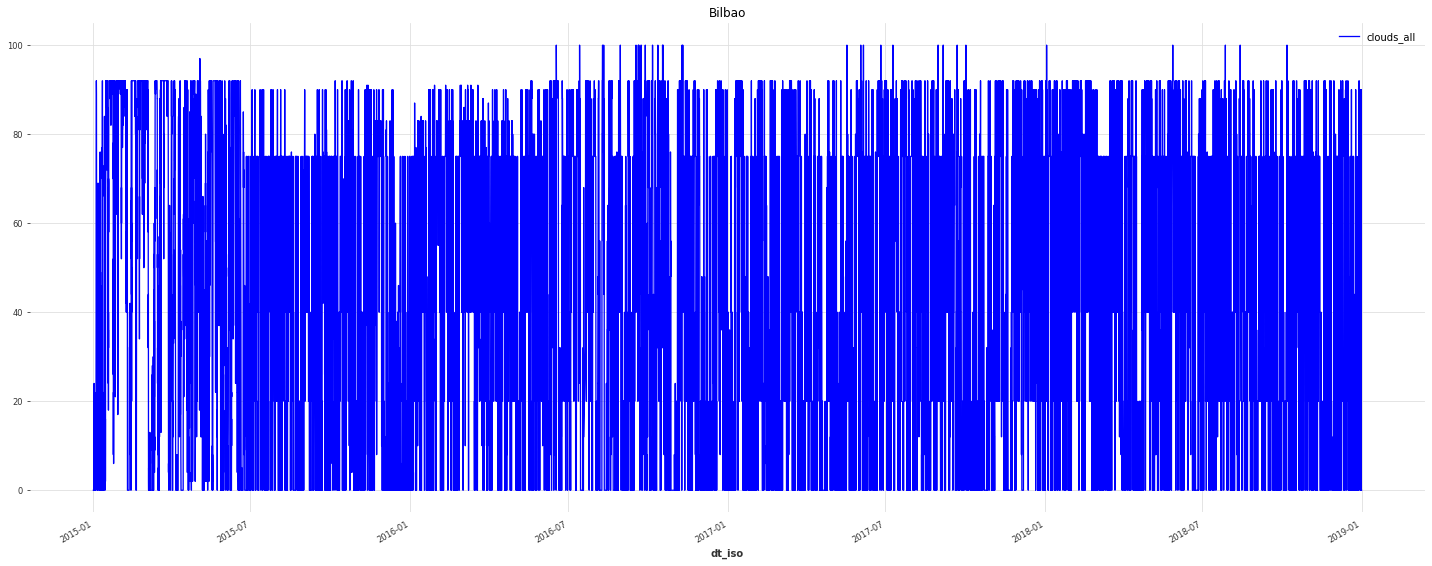

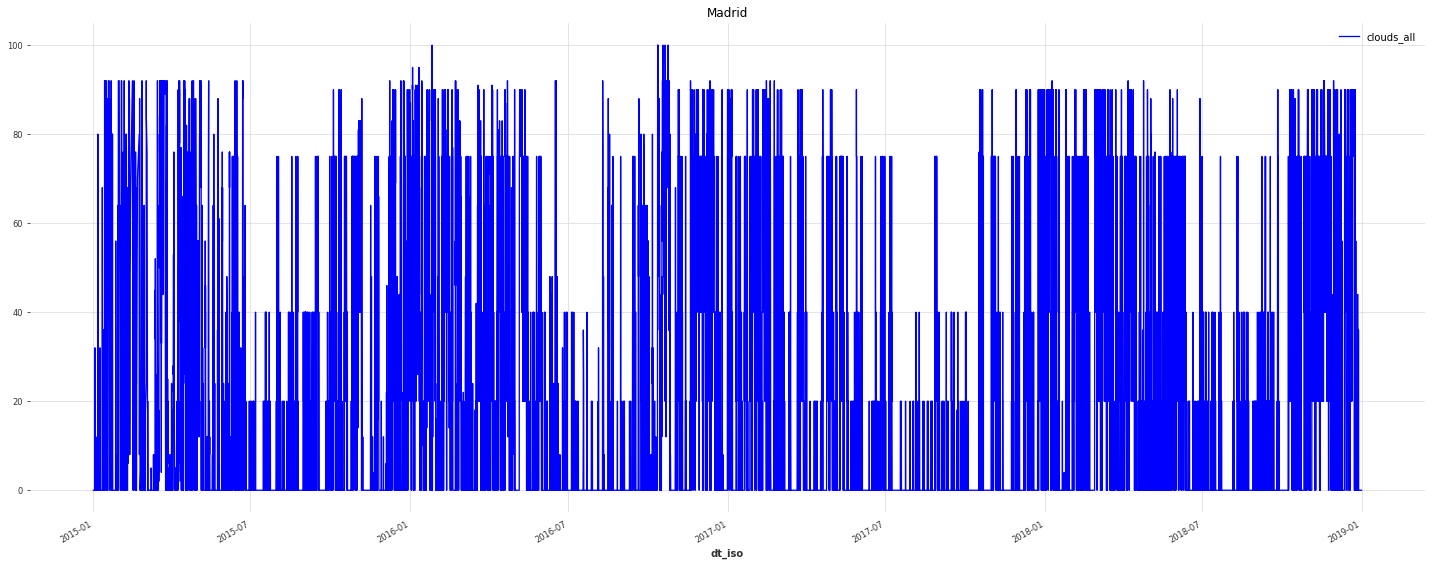

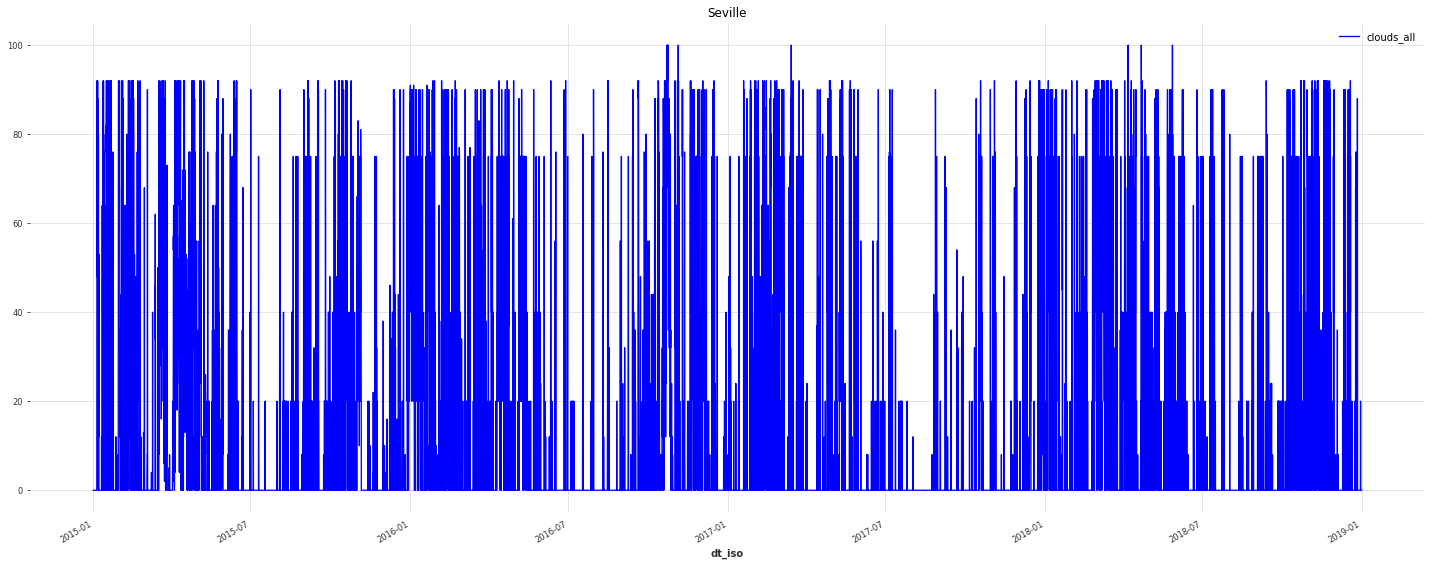

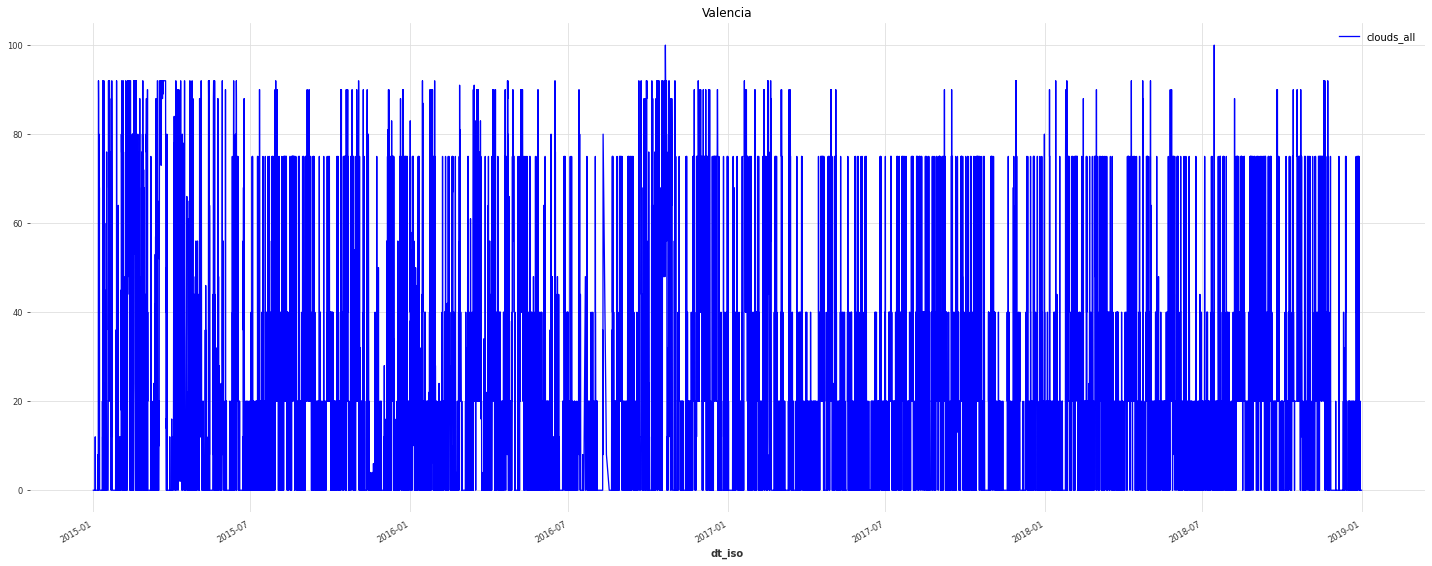

In [65]:
# graph the clouds for each city
grp = df_weather.groupby('city_name')[['clouds_all']] 
for key in grp.groups.keys():
    grp.get_group(key).plot(title=key, color='blue')

# Very simply as Madrid is the least cloudy that's the best spot for solar generation, and Valencia seems to have the highest values for wind although all cities have a similar mean. 

## Below is a plot of both daily and monthly average temperature for each city and the monthly total load (divided by 1000 to allow it to fit on the same graph) and price. There is some indication of seasonality in the total load, namely 2 peaks per year, one in January and one in June/July. This makes sense as it relates to the need for cooling (air conditioners) in summer and heating (electric heaters) in winter. The first graph (daily values) is a bit messy so the same data is resampled monthly to give a cleaner plot in the second graph.

## It is very difficult to see any particular pattern in the pricing with some maximums in July and January but also minimums there and max/mins in other months.

Text(0.5, 0, 'Year')

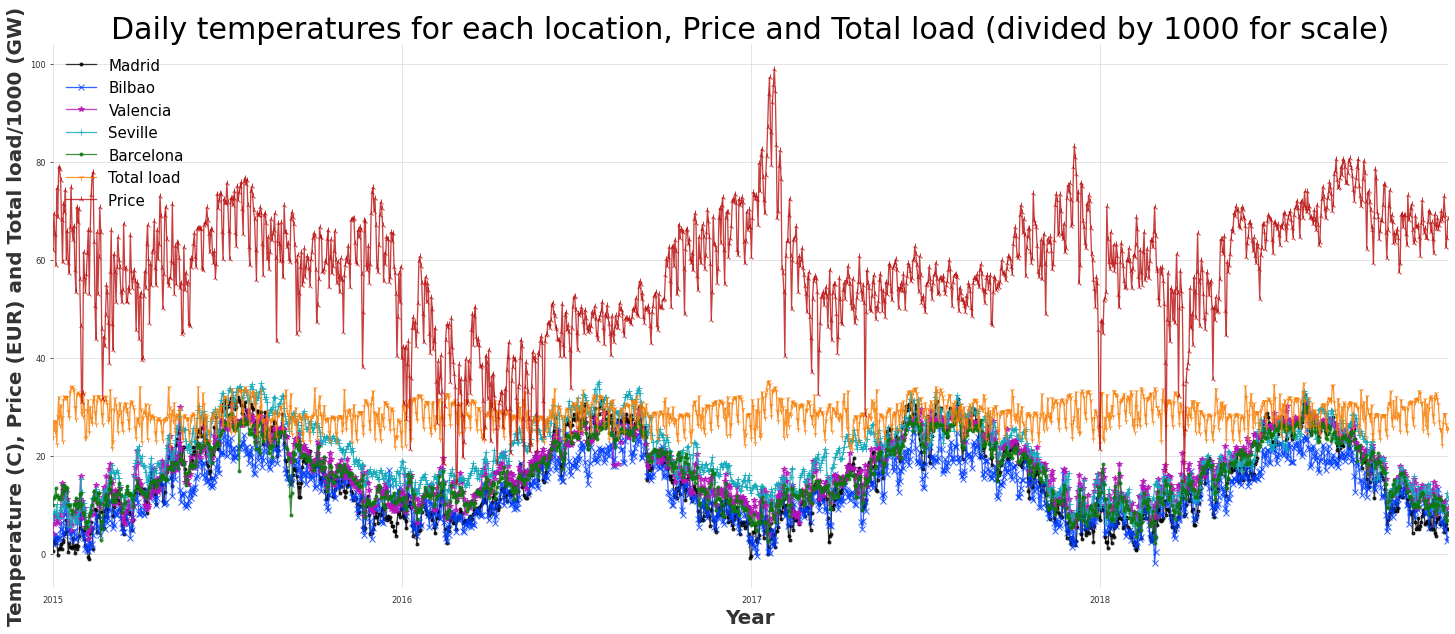

In [66]:
# Plots of daily temps for all 3 cities - change the resample value from M to D for Daily,  H for Hourly or W for Weekly.
axes = df_weather[df_weather.city_name=='Madrid'    ]["temp_C"].resample("D").mean().plot(marker='.', alpha=0.8,  label='Madrid' )
axes = df_weather[df_weather.city_name=='Bilbao'    ]["temp_C"].resample("D").mean().plot(marker='x', alpha=0.8,  label='Bilbao')
axes = df_weather[df_weather.city_name=='Valencia'  ]["temp_C"].resample("D").mean().plot(marker='*', alpha=0.8,  label='Valencia')
axes = df_weather[df_weather.city_name=='Seville'   ]["temp_C"].resample("D").mean().plot(marker='+', alpha=0.8,  label='Seville')
axes = df_weather[df_weather.city_name==' Barcelona']["temp_C"].resample("D").mean().plot(marker='.', alpha=0.8,  label='Barcelona')
# divide total load by 1000 to get similar scale
axes = df_energy['total load actual'].resample("D").mean().div(1000).plot(marker='1', alpha=0.8,   label='Total load')
axes = df_energy['price actual'].resample("D").mean().plot(marker='2', alpha=0.8, label='Price ')
axes.legend(loc='best', frameon=False, fontsize=15)
axes.set_title('Daily temperatures for each location, Price and Total load (divided by 1000 for scale)', fontsize=30)
axes.set_ylabel('Temperature (C), Price (EUR) and Total load/1000 (GW)', fontsize=20)
axes.set_xlabel("Year", fontsize=20)

# Below is the same graph as as above but resampled monthly rather than daily to make the graph easier to visualise

Text(0.5, 0, 'Year')

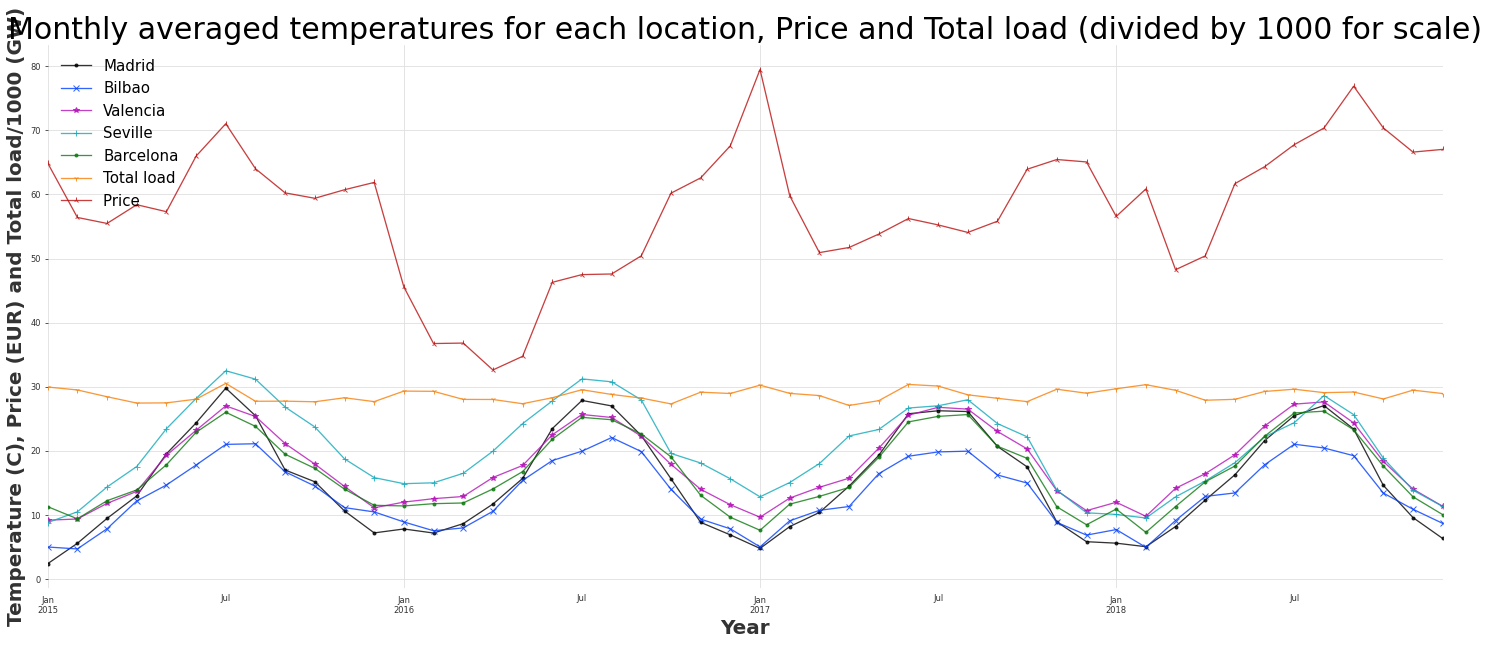

In [67]:
# Plots of daily temps for all 3 cities - change the resample value from M to D for Daily,  H for Hourly or W for Weekly.
axes = df_weather[df_weather.city_name=='Madrid'    ]["temp_C"].resample("M").mean().plot(marker='.', alpha=0.8, label='Madrid' )
axes = df_weather[df_weather.city_name=='Bilbao'    ]["temp_C"].resample("M").mean().plot(marker='x', alpha=0.8,  label='Bilbao')
axes = df_weather[df_weather.city_name=='Valencia'  ]["temp_C"].resample("M").mean().plot(marker='*', alpha=0.8,  label='Valencia')
axes = df_weather[df_weather.city_name=='Seville'   ]["temp_C"].resample("M").mean().plot(marker='+', alpha=0.8,  label='Seville')
axes = df_weather[df_weather.city_name==' Barcelona']["temp_C"].resample("M").mean().plot(marker='.', alpha=0.8, label='Barcelona')
# divide total load by 1000 to get similar scale
axes = df_energy['total load actual'].resample("M").mean().div(1000).plot(marker='1', alpha=0.8,  label='Total load')
axes = df_energy['price actual'].resample("M").mean().plot(marker='2', alpha=0.8,  label='Price ')
axes.legend(loc='best', frameon=False, fontsize=15)
axes.set_title('Monthly averaged temperatures for each location, Price and Total load (divided by 1000 for scale)', fontsize=30)
axes.set_ylabel('Temperature (C), Price (EUR) and Total load/1000 (GW)', fontsize=20)
axes.set_xlabel("Year", fontsize=20)

# Lastly to see if temperature affects the total demand a simple plot of temperature versus demand will be shown - a patterns will emerge - firstly graph monthly mean, then daily mean and finally hourly mean vs total hourly demand at the same samply frequency.
## An obvious pattern emerges with both warmer and colder temperatures having higher total loads - the pattern is more obvious when averaged over a month, on a daily average the pattern is not really recognisable but there is evidence of a pattern in the hourly data - though not as cleanly displayed.

# Thus is can be stated that temperature does play a role in electricity demand, in both higher and low temperatures the demand is greater.

Text(0.5, 1.0, 'Monthly Temperature versus Monthly Total Load')

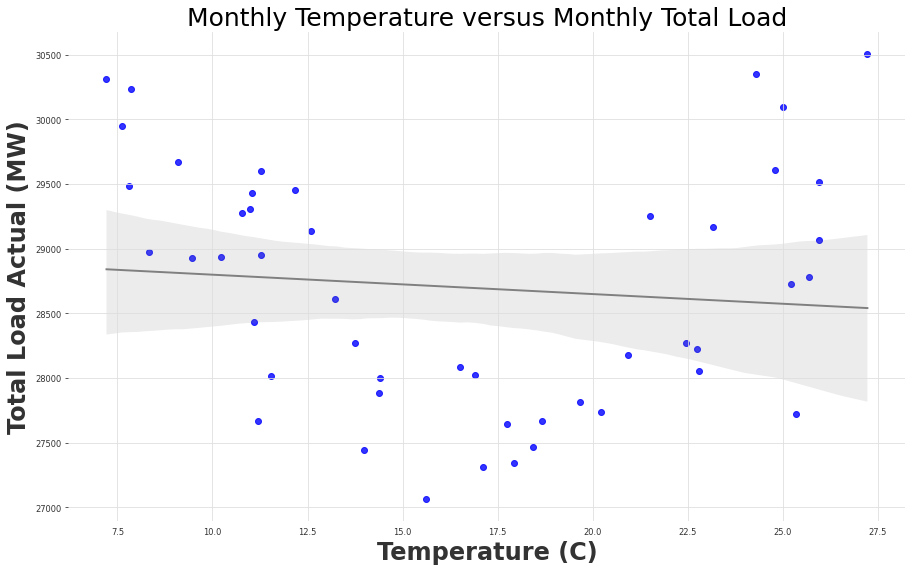

In [68]:
# Firstly monthly resamples
mean_temp   = df_weather[["temp_C"]].resample("M").mean() 
mean_energy = df_energy[['total load actual']].resample("M").mean()
#join the 2 df's
to_concat = [mean_temp,mean_energy]
result = pd.concat(to_concat,axis=1)

# plot of hours actual price vs hourly total load
plt.figure(figsize=(15,9))
# plot in blue with line of best fit in red
sns.regplot(x=result['temp_C'],y=result['total load actual'], scatter_kws={"color": "blue"}, line_kws={"color": "grey"})
plt.ylabel('Total Load Actual (MW)', fontsize=24)
plt.xlabel('Temperature (C)', fontsize=24)
plt.title("Monthly Temperature versus Monthly Total Load", fontsize=25)

Text(0.5, 1.0, 'Daily Temperature versus Daily Total Load')

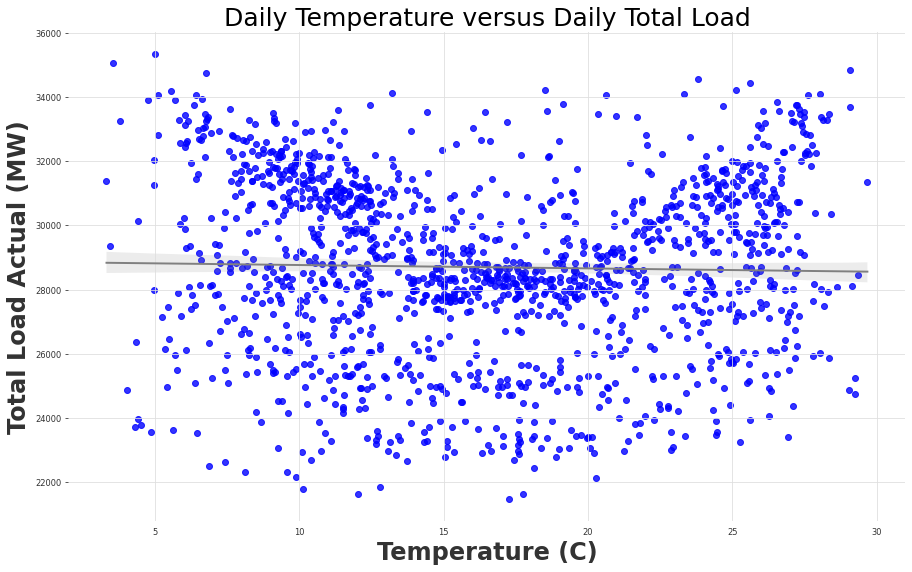

In [69]:
# Second daily resamples
mean_temp   = df_weather[["temp_C"]].resample("D").mean() 
mean_energy = df_energy[['total load actual']].resample("D").mean()
#join the 2 df's
to_concat = [mean_temp,mean_energy]
result = pd.concat(to_concat,axis=1)

# plot of hours actual price vs hourly total load
plt.figure(figsize=(15,9))
# plot in blue with line of best fit in red
sns.regplot(x=result['temp_C'],y=result['total load actual'], scatter_kws={"color": "blue"}, line_kws={"color": "grey"})
plt.ylabel('Total Load Actual (MW)', fontsize=24)
plt.xlabel('Temperature (C)', fontsize=24)
plt.title("Daily Temperature versus Daily Total Load", fontsize=25)

Text(0.5, 1.0, 'Hourly Temperature versus Hourly Total Load')

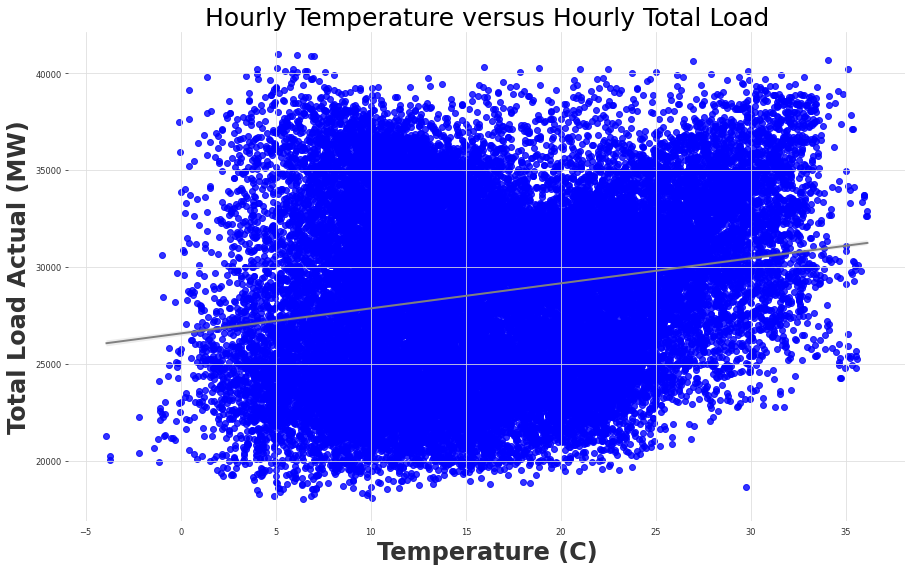

In [70]:
# lastly hourly samples
mean_temp   = df_weather[["temp_C"]].resample("H").mean() 
mean_energy = df_energy[['total load actual']].resample("H").mean()
#join the 2 df's
to_concat = [mean_temp,mean_energy]
result = pd.concat(to_concat,axis=1)

# plot of hours actual price vs hourly total load
plt.figure(figsize=(15,9))
# plot in blue with line of best fit in red
sns.regplot(x=result['temp_C'],y=result['total load actual'], scatter_kws={"color": "blue"}, line_kws={"color": "grey"})
plt.ylabel('Total Load Actual (MW)', fontsize=24)
plt.xlabel('Temperature (C)', fontsize=24)
plt.title("Hourly Temperature versus Hourly Total Load", fontsize=25)

# <b> 3. <i>Can we forecast 24 hours in advance better than the TSO?</i></b>
### The way I am going to go about this is to use methods from within the sktime, Auto_TS and DARTS libraries to forecast the energy use for the next day and compare that with the total load forecast feature for that day.

### For this we need to develop a model and this requires splitting data into training and testing dataset so the accuracy of the model can be assessed. The years 2015, 2016, 2017 become the training data set and 2018 becomes the test dataset to see how the models generated performs.

## The y value is simply the total load forecast value from the energy data. Since we are trying to forecast 24 hours in advance better than the TSO the resampling should be daily

### First calculate the mean average percentage error (MAPE) from the forecast versus the actual to get the TSO error - for all years

### The simple answer is no not with this simplistic technique - a multivariate technique is required to use the given inputs more effectively - rather than simply trying to 'learn' the pattern from the single 'total load forecast' values.

In [71]:
df_energy.isna().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual                                   0
total generation    

In [72]:
# For the hourly data
print('The mean absolute percentage error = {:.2f}%'.format(mean_absolute_percentage_error(df_energy['total load forecast'],df_energy['total load actual'])*100))
      

The mean absolute percentage error = 1.09%


In [73]:
# resampled daily
print('The mean absolute percentage error rsampled daily = {:.2f}%'.format(mean_absolute_percentage_error(df_energy['total load forecast'].resample('D').mean(),df_energy['total load actual'].resample('D').mean())*100))
      

The mean absolute percentage error rsampled daily = 0.82%


In [74]:
print('The RMSE error = {:.2f}%'.format(mean_squared_error(df_energy['total load actual'].resample('D').mean(),df_energy['total load forecast'].resample('D').mean(), squared=False)))

The RMSE error = 309.22%


In [75]:
from sklearn.metrics import mean_absolute_error
print('The MAE error = {:.2f}%'.format(mean_absolute_error(df_energy['total load actual'][df_energy.index.year==2018],df_energy['total load forecast'][df_energy.index.year==2018])))

The MAE error = 269.74%


In [76]:
# just for 2018 - no difference - so this is the number that needs to be beaten to show we can forecast better than the TSO


print('The mean absolute percentage error for 2018 = {:.2f}%'.format(mean_absolute_percentage_error(df_energy['total load forecast'][df_energy.index.year==2018],df_energy['total load actual'][df_energy.index.year==2018])*100))
#      ,round(mean_absolute_percentage_error(df_energy['total load forecast'][df_energy.index.year==2018],df_energy['total load actual'][df_energy.index.year==2018])*100,2),'%')

The mean absolute percentage error for 2018 = 0.92%


#  So this is the number that needs to be beaten to show we can forecast better than the TSO - a MAPE < 0.92%, but this compares the forecast to the actual and initally I am trying to learn from the first 3 years of data to predict the 4th year. A comparison is then made between the predicted forecast and the actual forecast

Text(0.5, 0, 'Year')

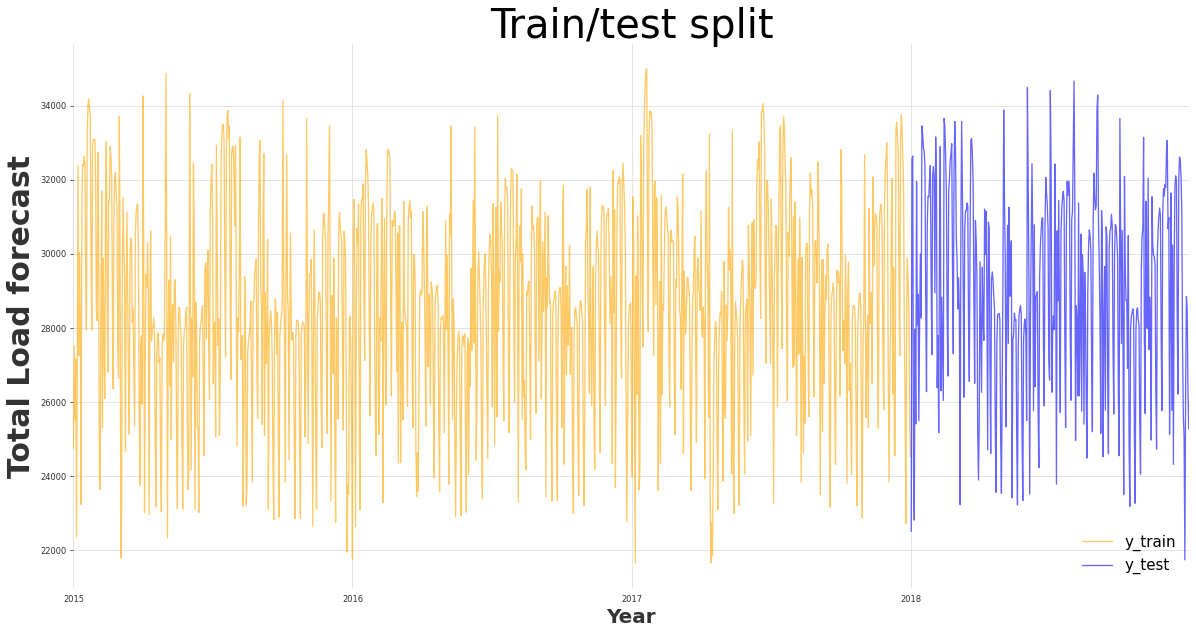

In [77]:
# Training data is years 2015, 2016,2017 and test data is 2018. - can be D M or H
y = df_energy[['total load forecast']].resample("D").mean() 
y = y.tz_localize(None)
#X = df_weather[['temp_C','humidity']]
y_train = y[y.index.year!=2018]
y_test = y[y.index.year>=2018]

# plot or train/test split
fig, axes = plt.subplots(1,1, figsize=(20, 10))

y_train.plot(ax=axes, alpha=0.6, color='orange') 
y_test.plot(ax=axes, alpha=0.6, color='blue') 
axes.legend(['y_train', 'y_test'], fontsize=15, loc=4)
axes.set_title('Train/test split', fontsize=40)
axes.set_ylabel('Total Load forecast', fontsize=30)
axes.set_xlabel("Year", fontsize=20)

In [78]:
# to get around the freq bug - set up the y_test, y_train index

y_train.index = pd.PeriodIndex(y_train.index, freq="D")  # added, assuming daily data - can be D M or H
y_test.index = pd.PeriodIndex(y_test.index, freq="D") 

# checking the start/end dates - they line up to the start and end times.
print('y_train start',y_train.head(1)) # start of 2015
print('y_train end  ',y_train.tail(1))   # end of 2017
print('y_test start ',y_test.head(1))   # start of 2018
print('y_test end   ',y_test.tail(1))   # end of 2018

y_train start             total load forecast
time                           
2015-01-01             24753.25
y_train end               total load forecast
time                           
2017-12-31              24533.0
y_test start              total load forecast
time                           
2018-01-01         22518.166667
y_test end                total load forecast
time                           
2018-12-31         25949.217391


# Several forecaters will try and learn the total load foreecast from 3 years of data (2015-2017) to make a prediction for the test data of 2018, some will provide graphs for simple visualisation (test/prediction comparisons). The comparison values is the Mean Average Percentage Error (MAPE)
## The Theta forecasters captures the shape but not the extremes - MAPE = 8.9%
## Exponential smoothing is slightly worse - MAPE = 13.1%

In [79]:
# this function outputs the MAPE  from the Theta forecaster using sktime

def sktime_Theta_forecasters_output():

    forecaster = ThetaForecaster(sp=365)  # if freq='H' sp = 365*24 if freq='D' sp=365, if freq='M' sp-12
    forecaster.fit(y_train)

    fh = np.arange(1,len(y_test) +1)  # forecasting horizon

    y_pred = forecaster.predict(fh)
    mean_absolute_percentage_error(y_pred, y_test)

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    #y_train.plot(ax=ax, label='y_train', style='.-')
    y_test.plot(ax=ax, label='y_test', alpha=0.5, style='.-',color='orange')
    y_pred.plot(ax=ax, label='y_predict', alpha=0.5, style='.-', color='blue')
    #df_energy['total load actual'][df_energy.index.year==2018].plot(ax=ax, label='forecast', alpha=0.5, style='.-')
    ax.legend(['y_test','y_pred'], fontsize=25, loc=2)
    ax.set_title('Test set and predictions for Theta forecaster', fontsize=40)
    ax.set_ylabel('Total Load forecast', fontsize=30)
    ax.set_xlabel("Year", fontsize=20)
    print('The mean absolute percentage error = {:.2f}%'.format(mean_absolute_percentage_error(y_pred, y_test)*100))

    return y_pred

The mean absolute percentage error = 8.91%


/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


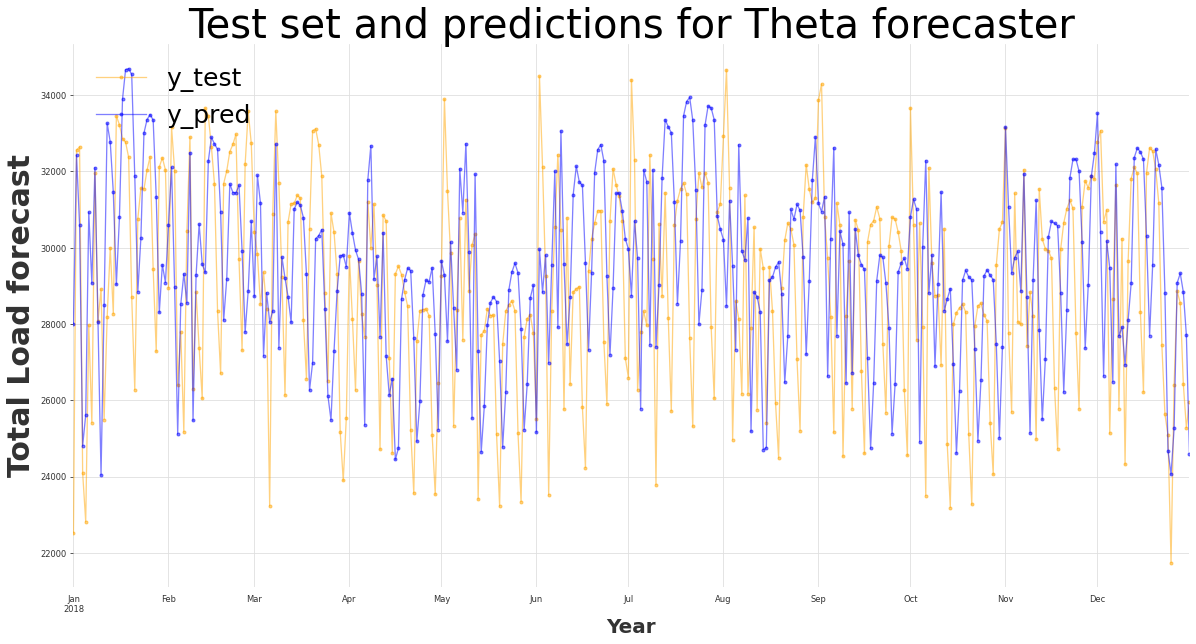

In [80]:
y_pred = sktime_Theta_forecasters_output()

## What we actually need to compare is the predicted versus the 'total load actual' so we are comparing the prediction of the total load forecast vs total load actual for the MAPE 

In [81]:
print('The mean absolute percentage error for Theta forecaster = ',round(mean_absolute_percentage_error(y_pred, df_energy['total load actual'][df_energy.index.year==2018].resample("D").mean())*100,1),'%')  #.resample('H').mean()

The mean absolute percentage error for Theta forecaster =  8.9 %


In [82]:
# RMSE error 

print('The RMSE error for the Theta forecater = {:.2f}%'.format(mean_squared_error(y_pred,df_energy['total load forecast'][df_energy.index.year==2018].resample('D').mean(), squared=False)))

The RMSE error for the Theta forecater = 3106.91%


In [83]:
# Exponential smoothing using sktime
def sktime_Exponential_Smoothing():

    forecaster = ExponentialSmoothing(trend="add", seasonal="add", sp=365)

    forecaster.fit(y_train)

    fh = np.arange(1,len(y_test)+1 )  # forecasting horizon
    #fh = ForecastingHorizon(y_test.index, is_relative=False)
    y_pred = forecaster.predict(fh)
    plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
    #mean_absolute_percentage_error(y_pred, y_test)
    print('The mean absolute percentage error = {:.2f}%'.format(mean_absolute_percentage_error(y_pred, y_test)*100,3))
    return y_pred

# I could not get the exponential smoothing functions to work (either above indiviudually or in the ensemble below) - ExponentialSmoothing both crashe

# So now try using Ensemble techniques using sktime, resample daily and see if scores are ok. Though be resampling daily it reduces the samples in the training data and so there are convergence issues.

In [84]:
# #sktime
# y = df_energy[['total load forecast']].resample("D").mean() 

# y_train = y[y.index.year!=2018]
# y_test = y[y.index.year>=2018]
# # to get around the freq bug - set up the y_test, y_train index

# y_train.index = pd.PeriodIndex(y_train.index, freq="D")  # added, assuming daily data - can be D M or H
# y_test.index = pd.PeriodIndex(y_test.index, freq="D") 


In [85]:
# #from sktime.forecasting.model_selection import temporal_train_test_split
# from sktime.forecasting.compose import AutoEnsembleForecaster
# from sktime.forecasting.naive import NaiveForecaster

# from sktime.forecasting.trend import PolynomialTrendForecaster
# #from sktime.forecasting.tbats import TBATS
# from sktime.forecasting.arima import AutoARIMA

# fh = np.arange(1,len(y_test) +1)  # forecasting horizon

# forecasters = [
#     #("trend", PolynomialTrendForecaster()),
#     #("naive", NaiveForecaster()),
#     ("theta", ThetaForecaster(sp=365)),
#     ("AutoARIMA",AutoARIMA(sp=365)) ,
#             ]


# ensemble = AutoEnsembleForecaster(forecasters= forecasters)
# ensemble.fit(y_train,fh=fh)
# #print(ensemble.forecasters_)

In [86]:
#pred = ensemble.predict(y_test)

In [87]:
# fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# #y_train.plot(ax=ax, label='y_train', style='.-')
# y_test.plot(ax=ax, label='y_test', alpha=0.5, style='.-')
# y_pred.plot(ax=ax, label='y_predict', alpha=0.5, style='.-')
# #df_energy['total load actual'][df_energy.index.year==2018].plot(ax=ax, label='forecast', alpha=0.5, style='.-')
# ax.legend(['y_test','y_pred'], fontsize=25, loc=2)
# ax.set_title('Test set and predictions for Ensemble forecaster', fontsize=40)
# ax.set_ylabel('Total Load forecast', fontsize=30)
# ax.set_xlabel("Year", fontsize=20)
# print('The symmetric mean absolute percentage error between the forecast made and the actual forecast = ',round(mean_absolute_percentage_error(y_pred, y_test)*100,1),'%')

# Now using DARTS for timeseries modelling

## Need to load the energy dataframe into a TimeSeries - this is the way Darts works

In [88]:
# check for  duplicates
print("count of duplicates:",df_energy.index.duplicated().sum())

count of duplicates: 0


In [89]:
# create the energy timeseries from the total load forecast -- resample to D as forecasting usage for next 24 hours.

energy_ts = TimeSeries.from_dataframe(df_energy.resample('D').mean(), value_cols='total load forecast', freq='D', fillna_value=True,  fill_missing_dates=True)


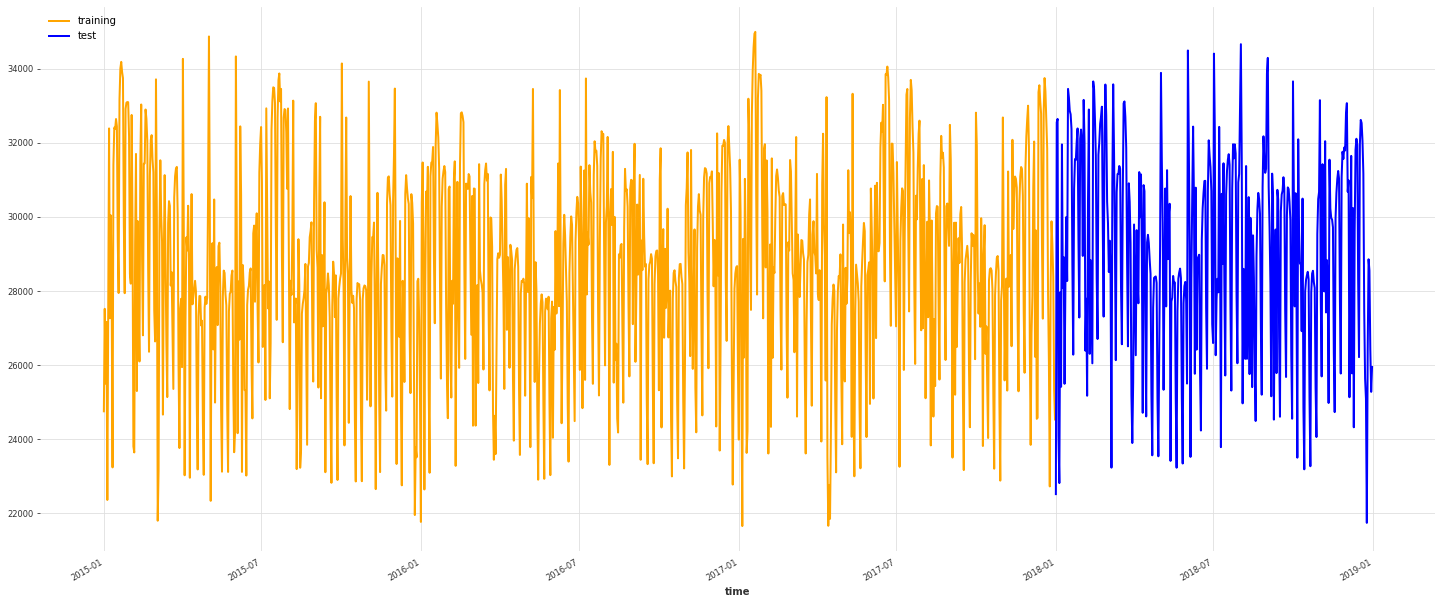

In [90]:
train, test = energy_ts.split_before(pd.Timestamp('20180101'))
train.plot(label='training', color='orange')
test.plot(label='test', color='blue')
plt.legend(loc=2);

# Check for seasonality - none evident so some of the seasonal models will not produce great results

In [91]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(energy_ts, m=m, alpha=.05)
    if is_seasonal:
        print('There is seasonality of order {}.'.format(period))
    else:         
        print('not seasonal')  
        break;


not seasonal


# Not having had much success with sktime and wanting to experiment I then tried the NBEATS (Neural basis expansion analysis for interpretable time series forecasting) using a pytorch implementation from the Darts library. Whilst it has a low training loss, the prediction made can still be seen to be innaccurate, with a MAPE of 64%. The enhances the thought that a multivariate solution is needed.

In [92]:
import torch

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


In [93]:
# scale the data so all vairables between 0,1
scaler_energy = Scaler()
energy_ts_scaled = scaler_energy.fit_transform(energy_ts)

In [94]:
# train/test split
train_energy, test_energy = energy_ts_scaled.split_before(pd.Timestamp('20180101'))

In [95]:
# set up the model
model_energy = NBEATSModel(
    input_chunk_length=24, 
    output_chunk_length=12,
    num_stacks=2,
    num_blocks=1, 
    num_layers=2, 
    layer_widths=32,
    n_epochs=100, 
    random_state=42,
    batch_size=72
)

In [96]:
# fit the model
model_energy.fit(train_energy, verbose=True)

[2022-05-01 19:29:05,737] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1061 samples.
[2022-05-01 19:29:05,737] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1061 samples.
[2022-05-01 19:29:05,743] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-05-01 19:29:05,743] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/100 [00:00<?, ?it/s]

In [97]:
# create a prediction and then unscale the data
pred = model_energy.predict(n=len(test), series= train_energy)
pred_unscale = scaler_energy.inverse_transform(pred)
test_unscale = scaler_energy.inverse_transform(test_energy)

MAPE = 64.75%


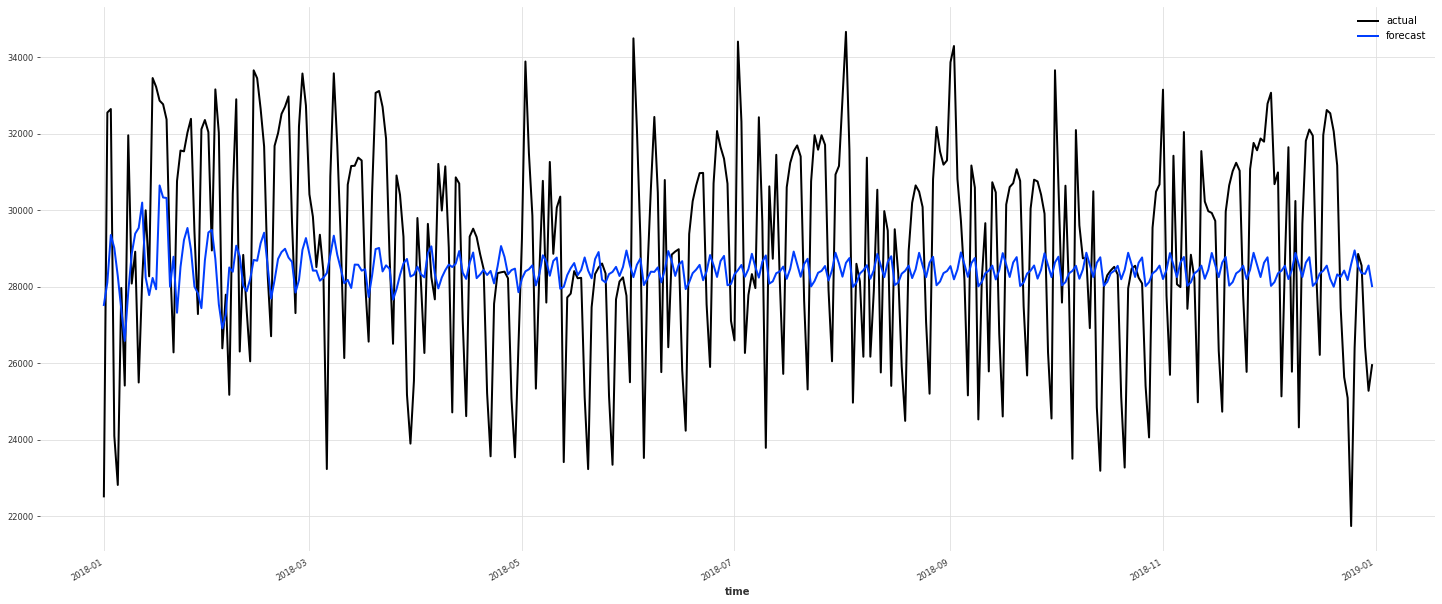

In [98]:
#plot the unscaled data
test_unscale.plot(label="actual")
pred_unscale.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(energy_ts_scaled, pred)))

# Finally check Exponential Smoothing (this version from Darts works when I couldn't get sktimes version to work), Facebook Prophet, AutoArima and Theta models to run and give results.
## the best MAPE is from the Facebook Prophet model at 6.1%, as can be seen in the graph. But can we do better with a  mutlivariate model ?

/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=7 obtains MAPE: 18.9%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model Prophet obtains MAPE: 6.1%


[2022-05-01 19:29:29,135] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 3
[2022-05-01 19:29:29,135] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 3
INFO:darts.models.forecasting.theta:Theta model inferred seasonality of training series: 3


model Auto-ARIMA obtains MAPE: 8.0%
model Theta(1) obtains MAPE: 8.7%


/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


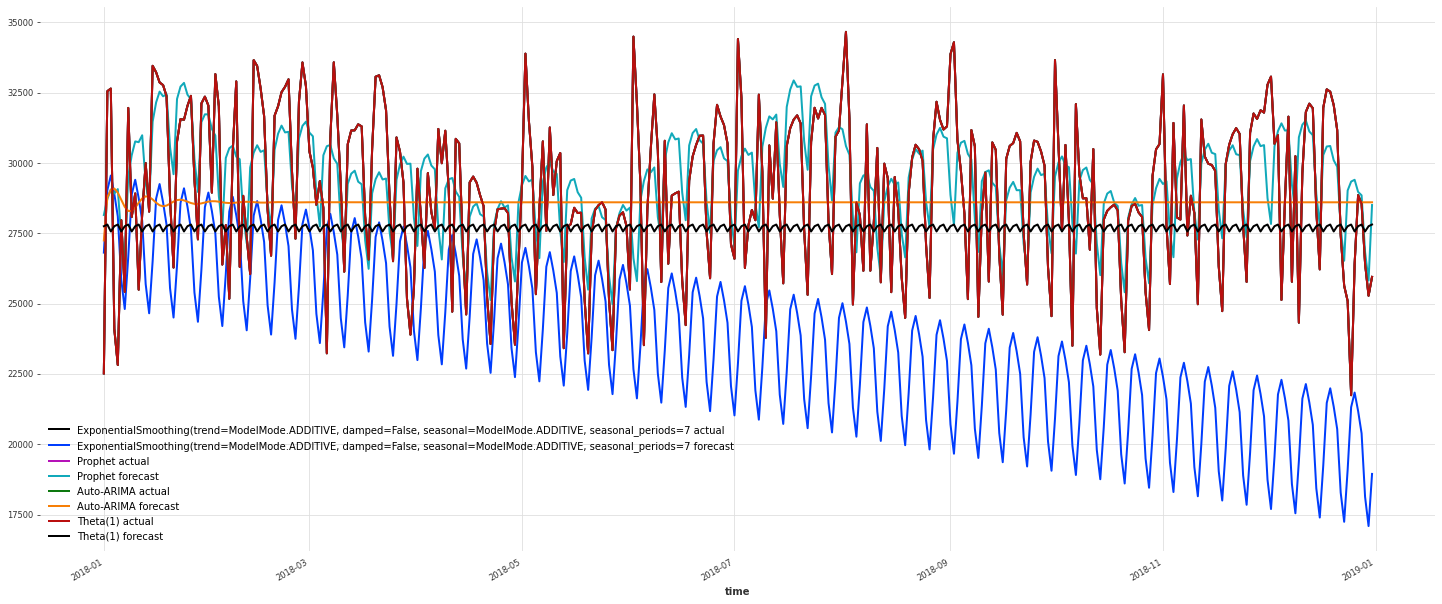

In [99]:
# define a simply function to test each type of model
def evaluate_model(model):
    # fit the model on the training dataset
    model.fit(train)
    # model prediction on the test set
    pred = model.predict(len(test))
    test.plot(label=str(model)+" actual")
    pred.plot(label=str(model)+" forecast")
    print('model {} obtains MAPE: {:.1f}%'.format(model, mape(test, pred)))

evaluate_model(ExponentialSmoothing())
evaluate_model(Prophet())
evaluate_model(AutoARIMA())
evaluate_model(Theta(theta =  1)) 

# To model the timeseries as multivariate it becomes necessary to join the weather and energy datasets and look for some correlations. Need to use merge to join the datasets based on their common index values (don't want duplicates). 

## Since there are weather values for all 5 cities take the mean across all the cities - this will miss some extremes but is an easy way to summarise the weather df and then join with the energy df

In [100]:
# Create a combined df of teh information from the 5 cities by taking the mean of the values for each hour.
df_weather_combined = df_weather.resample("H").mean()
df_weather_combined.index.rename('Datetime', inplace=True)

In [101]:
df_weather_combined.head()

pressure  humidity  wind_speed  wind_deg  rain_1h  \
Datetime                                                                 
2015-01-01 00:00:00    1016.2      82.4         2.0     135.8      0.0   
2015-01-01 01:00:00    1016.8      82.0         2.4     119.0      0.0   
2015-01-01 02:00:00    1035.0      97.0         1.0     225.0      0.0   
2015-01-01 03:00:00    1035.0      97.0         1.0     221.0      0.0   
2015-01-01 04:00:00    1017.4      82.6         2.4     174.8      0.0   

                     snow_3h  clouds_all  temp_C  temp_C_max  temp_C_min  
Datetime                                                                  
2015-01-01 00:00:00      0.0         0.0   -0.64       -0.64       -0.64  
2015-01-01 01:00:00      0.0         0.0   -1.08       -1.08       -1.08  
2015-01-01 02:00:00      0.0         0.0   -3.90       -3.90       -3.90  
2015-01-01 03:00:00      0.0         0.0   -3.70       -3.70       -3.70  
2015-01-01 04:00:00      0.0         0.0   -1.14       -1.14       -1.14

In [102]:
df_energy.index.rename('Datetime', inplace=True)
df_energy.index.name

'Datetime'

In [103]:
# Next join the 2 datasets on the common index
df_joined = df_weather_combined.merge(df_energy, on='Datetime', how = 'inner')

In [104]:
df_joined.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2018-12-31 13:00:00', '2018-12-31 14:00:00',
               '2018-12-31 15:00:00', '2018-12-31 16:00:00',
               '2018-12-31 17:00:00', '2018-12-31 18:00:00',
               '2018-12-31 19:00:00', '2018-12-31 20:00:00',
               '2018-12-31 21:00:00', '2018-12-31 22:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=35063, freq=None)

In [105]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35063 entries, 2015-01-01 00:00:00 to 2018-12-31 22:00:00
Data columns (total 31 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   pressure                                     34468 non-null  float64
 1   humidity                                     34468 non-null  float64
 2   wind_speed                                   34468 non-null  float64
 3   wind_deg                                     34468 non-null  float64
 4   rain_1h                                      34468 non-null  float64
 5   snow_3h                                      34468 non-null  float64
 6   clouds_all                                   34468 non-null  float64
 7   temp_C                                       34468 non-null  float64
 8   temp_C_max                                   34468 non-null  float64
 9   temp_C_min                           

In [106]:
df_joined.isna().sum()

pressure                                       595
humidity                                       595
wind_speed                                     595
wind_deg                                       595
rain_1h                                        595
snow_3h                                        595
clouds_all                                     595
temp_C                                         595
temp_C_max                                     595
temp_C_min                                     595
generation biomass                               0
generation fossil brown coal/lignite             0
generation fossil gas                            0
generation fossil hard coal                      0
generation fossil oil                            0
generation hydro pumped storage consumption      0
generation hydro run-of-river and poundage       0
generation hydro water reservoir                 0
generation nuclear                               0
generation other               

In [107]:
df_joined.dropna(inplace=True)

In [108]:
df_joined.isna().sum()

pressure                                       0
humidity                                       0
wind_speed                                     0
wind_deg                                       0
rain_1h                                        0
snow_3h                                        0
clouds_all                                     0
temp_C                                         0
temp_C_max                                     0
temp_C_min                                     0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other ren

In [109]:
# check for  duplicates
df_joined.shape

(34468, 31)

In [110]:
df_joined.head()

pressure  humidity  wind_speed  wind_deg  rain_1h  \
Datetime                                                                 
2015-01-01 00:00:00    1016.2      82.4         2.0     135.8      0.0   
2015-01-01 01:00:00    1016.8      82.0         2.4     119.0      0.0   
2015-01-01 02:00:00    1035.0      97.0         1.0     225.0      0.0   
2015-01-01 03:00:00    1035.0      97.0         1.0     221.0      0.0   
2015-01-01 04:00:00    1017.4      82.6         2.4     174.8      0.0   

                     snow_3h  clouds_all  temp_C  temp_C_max  temp_C_min  ...  \
Datetime                                                                  ...   
2015-01-01 00:00:00      0.0         0.0   -0.64       -0.64       -0.64  ...   
2015-01-01 01:00:00      0.0         0.0   -1.08       -1.08       -1.08  ...   
2015-01-01 02:00:00      0.0         0.0   -3.90       -3.90       -3.90  ...   
2015-01-01 03:00:00      0.0         0.0   -3.70       -3.70       -3.70  ...   
2015-01-01 04:00:00      0.0         0.0   -1.14       -1.14       -1.14  ...   

                     generation solar  generation waste  \
Datetime                                                  
2015-01-01 00:00:00              50.0             195.0   
2015-01-01 01:00:00              50.0             196.0   
2015-01-01 02:00:00              50.0             191.0   
2015-01-01 03:00:00              42.0             189.0   
2015-01-01 04:00:00              34.0             188.0   

                     generation wind onshore  forecast solar day ahead  \
Datetime                                                                 
2015-01-01 00:00:00                   5890.0                      16.0   
2015-01-01 01:00:00                   5461.0                       8.0   
2015-01-01 02:00:00                   5238.0                       2.0   
2015-01-01 03:00:00                   4935.0                       9.0   
2015-01-01 04:00:00                   4618.0                       4.0   

                     forecast wind onshore day ahead  total load forecast  \
Datetime                                                                    
2015-01-01 00:00:00                           5856.0              24934.0   
2015-01-01 01:00:00                           5454.0              23515.0   
2015-01-01 02:00:00                           5151.0              22642.0   
2015-01-01 03:00:00                           4861.0              21785.0   
2015-01-01 04:00:00                           4617.0              21441.0   

                     total load actual  price day ahead  price actual  \
Datetime                                                                
2015-01-01 00:00:00            24382.0            48.10         64.92   
2015-01-01 01:00:00            22734.0            47.33         64.48   
2015-01-01 02:00:00            21286.0            42.27         59.32   
2015-01-01 03:00:00            20264.0            38.41         56.04   
2015-01-01 04:00:00            19905.0            35.72         53.63   

                     total generation  
Datetime                               
2015-01-01 00:00:00           26883.0  
2015-01-01 01:00:00           25868.0  
2015-01-01 02:00:00           24371.0  
2015-01-01 03:00:00           23849.0  
2015-01-01 04:00:00           23487.0  

[5 rows x 31 columns]

# Creating a correlation matrix and displaying it shows a few interesting things. Namely the temperature only has a 20% correlation with the total load actual. Two graphs shown - one for all correlations and then one with absolute values for correlations greater than 45%, lastly the specific correlations can be viewed in a list (select the field manually).

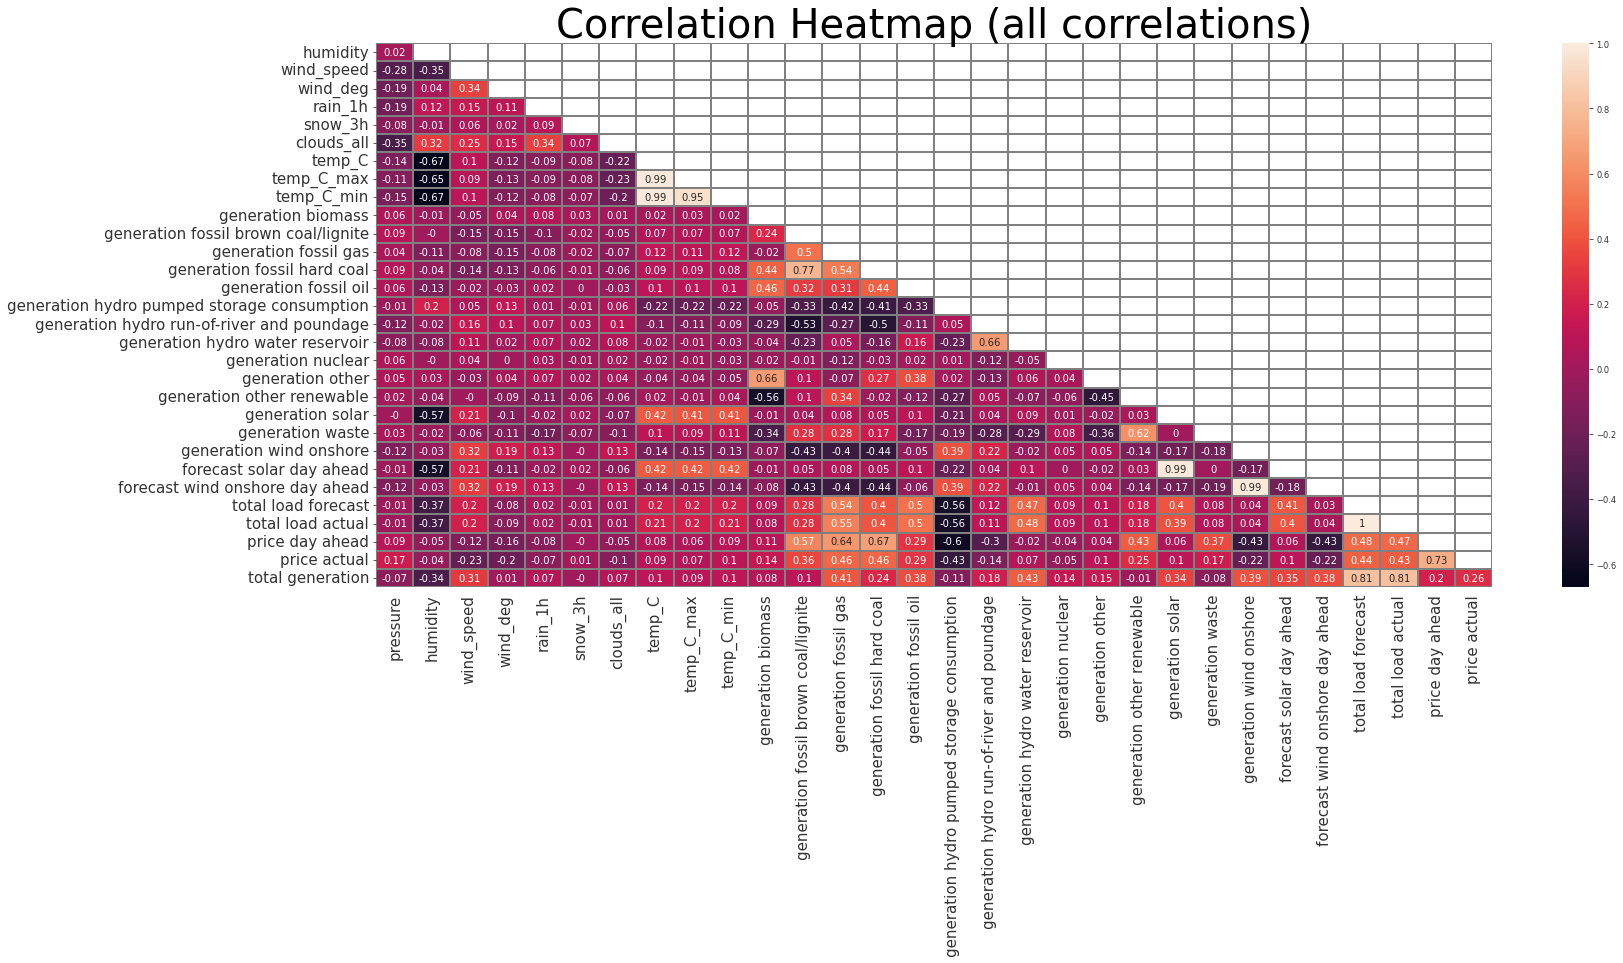

In [111]:
# To find the correlation among the columns using pearson method 

corr_matrix = df_joined.corr().round(2) # add in .abs() if not worried about positive or negative correlation just the strength


# use this to show only lower triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cut_off = -1 # to show all correlations

mask |= np.abs(corr_matrix) < cut_off
corr = corr_matrix[~mask]  # fill in NaN in the non-desired cells
# reove empty rows/columns to make it easier to read.
remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]
# display the correlation value in a grid to make it easier to read.
s = sns.heatmap(corr,annot=True,  linewidths=0.1, linecolor='gray')
# increase the size of the labels.
s.set_title('Correlation Heatmap (all correlations)', fontsize=40)
s.set_xticklabels(s.get_xmajorticklabels(), fontsize = 15)
s.set_yticklabels(s.get_ymajorticklabels(), fontsize = 15)
plt.show()

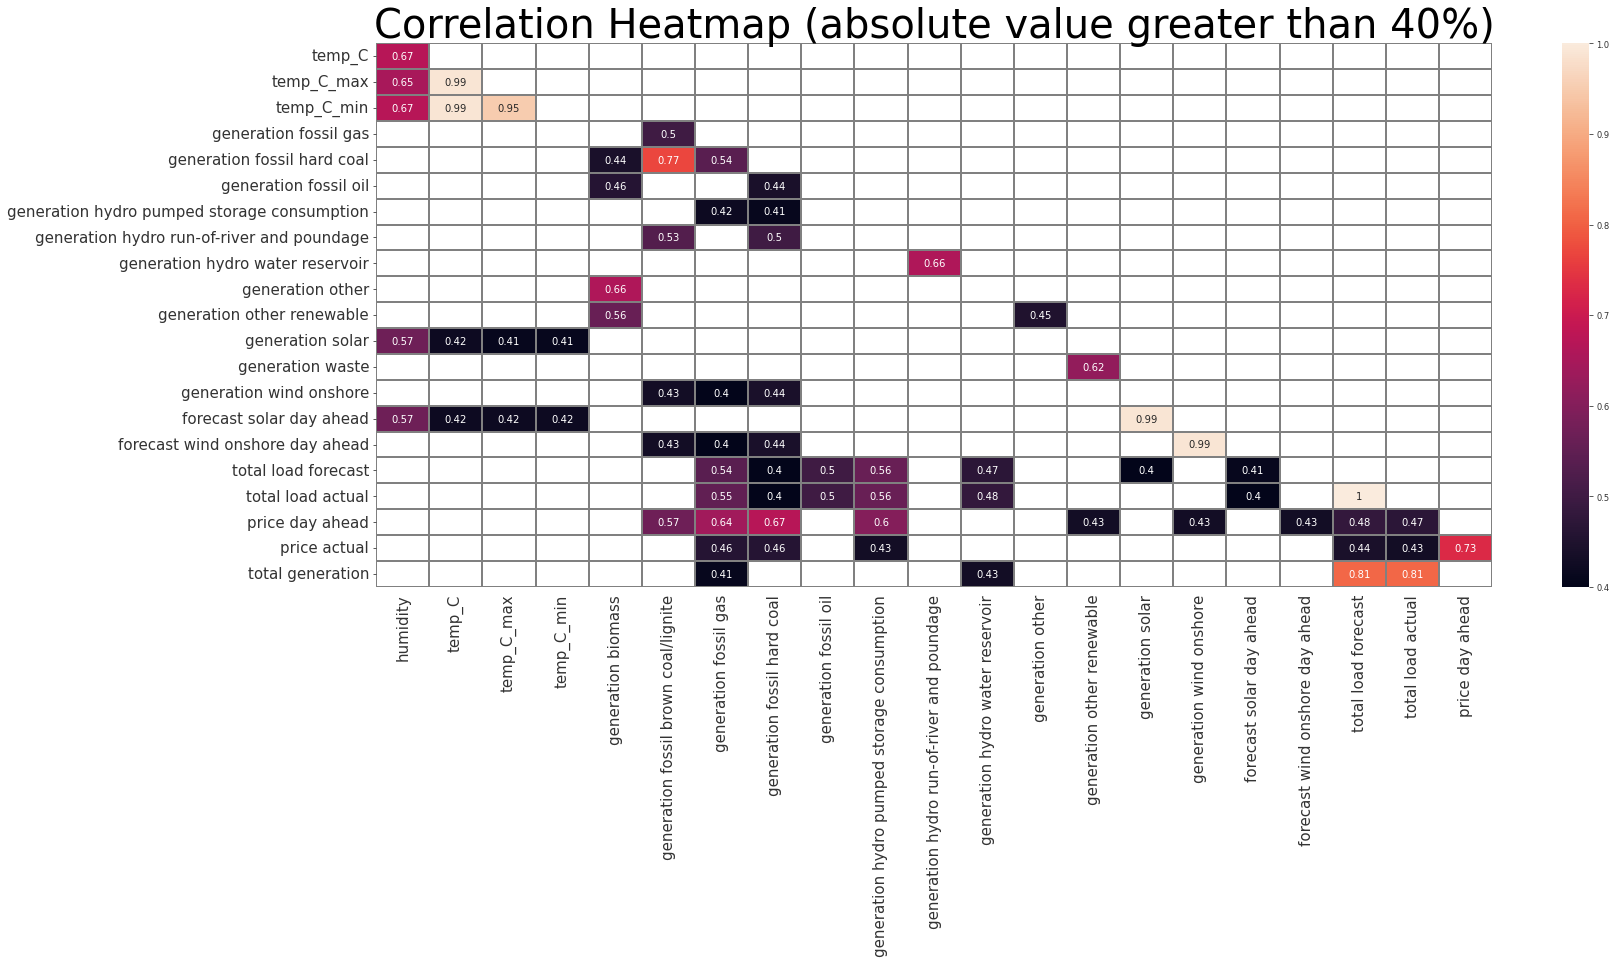

In [112]:
# To find the correlation among the columns using pearson method and then only display values with correlations > 45%

corr_matrix = df_joined.corr().abs().round(2) # add in .abs() if not worried about positive or negative correlation just the strength


# use this to show only lower triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cut_off = 0.40 # just show correlation greater than 40% 

mask |= np.abs(corr_matrix) < cut_off
corr = corr_matrix[~mask]  # fill in NaN in the non-desired cells
# reove empty rows/columns to make it easier to read.
remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]
# display the correlation value in a grid to make it easier to read.
s = sns.heatmap(corr,annot=True,  linewidths=0.1, linecolor='gray')
# increase the size of the labels.
s.set_title('Correlation Heatmap (absolute value greater than 40%)', fontsize=40)
s.set_xticklabels(s.get_xmajorticklabels(), fontsize = 15)
s.set_yticklabels(s.get_ymajorticklabels(), fontsize = 15)
plt.show()

# Another way of viewing the correlations - this list can be changed to see different specific correlations - just change the specified field in the last line.

In [113]:
# way of viewing specific correlations
correlations = df_joined.corr().unstack().sort_values(ascending=False).drop_duplicates().round(2)
correlations['total load actual']  # change the required field here to get the specific correlations

total load forecast                            1.00
total generation                               0.81
generation fossil gas                          0.55
generation fossil oil                          0.50
generation hydro water reservoir               0.48
price day ahead                                0.47
price actual                                   0.43
forecast solar day ahead                       0.40
temp_C_min                                     0.21
wind_speed                                     0.20
generation other renewable                     0.18
generation hydro run-of-river and poundage     0.11
generation nuclear                             0.09
generation biomass                             0.08
generation wind onshore                        0.04
clouds_all                                     0.01
snow_3h                                       -0.01
humidity                                      -0.37
generation hydro pumped storage consumption   -0.56
dtype: float

In [114]:
correlations['temp_C']  # change the required field here to get the specific correlations

temp_C_min                                     0.99
temp_C_max                                     0.99
forecast solar day ahead                       0.42
generation solar                               0.42
total load actual                              0.21
total load forecast                            0.20
generation fossil gas                          0.12
generation fossil brown coal/lignite           0.07
generation biomass                             0.02
generation other renewable                     0.02
generation hydro water reservoir              -0.02
generation other                              -0.04
snow_3h                                       -0.08
generation hydro run-of-river and poundage    -0.10
generation hydro pumped storage consumption   -0.22
humidity                                      -0.67
dtype: float64

# Since we are trying to predict the total load forecast value, the values correlated to that need to be included as predictors - from below we can see that the values to use are : 
## ['total generation','generation fossil gas','generation fossil oil','price day ahead','price actual','generation solar','temp_C_min','generation other renewable','generation biomass','generation waste','forecast wind onshore day ahead','clouds_all','snow_3h','wind_deg','humidity','generation hydro pumped storage consumption'] 

In [115]:
correlations['total load forecast']

total generation                               0.81
generation fossil gas                          0.54
generation fossil oil                          0.50
price day ahead                                0.48
price actual                                   0.44
generation solar                               0.40
temp_C_min                                     0.20
generation other renewable                     0.18
generation biomass                             0.09
generation waste                               0.08
forecast wind onshore day ahead                0.03
clouds_all                                     0.01
snow_3h                                       -0.01
wind_deg                                      -0.08
humidity                                      -0.37
generation hydro pumped storage consumption   -0.56
dtype: float64

# So the target variable is the total load forecast and the predictors are as above. Now to see if a multivariate model can be trained using this data (and whether it is more accurate that simple training on the total load forecast - first make a smaller dataframe with the variables needed, then set up y_train/test and X_train/test

In [116]:
# create a new df df_joined_pred - for prediction - only the correlated columns
df_joined_pred = df_joined[['total load forecast','total generation','generation fossil gas','generation fossil oil','price day ahead','price actual','generation solar','temp_C_min','generation other renewable',
                            'generation biomass','generation waste','forecast wind onshore day ahead','clouds_all','snow_3h','wind_deg','humidity','generation hydro pumped storage consumption']]
df_joined_pred.head()


total load forecast  total generation  \
Datetime                                                     
2015-01-01 00:00:00              24934.0           26883.0   
2015-01-01 01:00:00              23515.0           25868.0   
2015-01-01 02:00:00              22642.0           24371.0   
2015-01-01 03:00:00              21785.0           23849.0   
2015-01-01 04:00:00              21441.0           23487.0   

                     generation fossil gas  generation fossil oil  \
Datetime                                                            
2015-01-01 00:00:00                 5196.0                  158.0   
2015-01-01 01:00:00                 4857.0                  157.0   
2015-01-01 02:00:00                 4314.0                  160.0   
2015-01-01 03:00:00                 4130.0                  156.0   
2015-01-01 04:00:00                 4038.0                  156.0   

                     price day ahead  price actual  generation solar  \
Datetime                                                               
2015-01-01 00:00:00            48.10         64.92              50.0   
2015-01-01 01:00:00            47.33         64.48              50.0   
2015-01-01 02:00:00            42.27         59.32              50.0   
2015-01-01 03:00:00            38.41         56.04              42.0   
2015-01-01 04:00:00            35.72         53.63              34.0   

                     temp_C_min  generation other renewable  \
Datetime                                                      
2015-01-01 00:00:00       -0.64                        71.0   
2015-01-01 01:00:00       -1.08                        73.0   
2015-01-01 02:00:00       -3.90                        75.0   
2015-01-01 03:00:00       -3.70                        74.0   
2015-01-01 04:00:00       -1.14                        74.0   

                     generation biomass  generation waste  \
Datetime                                                    
2015-01-01 00:00:00               449.0             195.0   
2015-01-01 01:00:00               448.0             196.0   
2015-01-01 02:00:00               438.0             191.0   
2015-01-01 03:00:00               428.0             189.0   
2015-01-01 04:00:00               410.0             188.0   

                     forecast wind onshore day ahead  clouds_all  snow_3h  \
Datetime                                                                    
2015-01-01 00:00:00                           5856.0         0.0      0.0   
2015-01-01 01:00:00                           5454.0         0.0      0.0   
2015-01-01 02:00:00                           5151.0         0.0      0.0   
2015-01-01 03:00:00                           4861.0         0.0      0.0   
2015-01-01 04:00:00                           4617.0         0.0      0.0   

                     wind_deg  humidity  \
Datetime                                  
2015-01-01 00:00:00     135.8      82.4   
2015-01-01 01:00:00     119.0      82.0   
2015-01-01 02:00:00     225.0      97.0   
2015-01-01 03:00:00     221.0      97.0   
2015-01-01 04:00:00     174.8      82.6   

                     generation hydro pumped storage consumption  
Datetime                                                          
2015-01-01 00:00:00                                        920.0  
2015-01-01 01:00:00                                       1164.0  
2015-01-01 02:00:00                                       1503.0  
2015-01-01 03:00:00                                       1826.0  
2015-01-01 04:00:00                                       2109.0

# Lastly auto_ts - auto timeseries - here the Date has to be a column in the df not just the index - and now we are trying multivariate by using correlated  columns - this uses multiple models and selects the best results and then uses that model. Also set up train and test datasets 2015-2017 (3 years) for training and 2018 for testing.

# It takes a long time to run (at least an hour) and there is a lot of output from this method (several pages worth - so scroll through it to the bottom)

In [117]:
from auto_ts import auto_timeseries

# create train and test sets as usual

train, test = df_joined_pred['2015-01-01':'2017-12-31'], df_joined_pred['2018-01-01':'2018-12-31']

Imported auto_timeseries version:0.0.64. Call by using:
model = auto_timeseries(score_type='rmse',
        time_interval='M', non_seasonal_pdq=None, seasonality=False,
        seasonal_period=12, model_type=['best'], verbose=2, dask_xgboost_flag=0)
model.fit(traindata, ts_column,target)
model.predict(testdata, model='best')



In [118]:
# createa Date column
train['Date'] = train.index.values
test['Date'] = test.index.values

In [119]:
test.head()

total load forecast  total generation  \
Datetime                                                     
2018-01-01 00:00:00              22688.0           26776.0   
2018-01-01 01:00:00              21521.0           25408.0   
2018-01-01 02:00:00              20294.0           22267.0   
2018-01-01 03:00:00              19489.0           22428.0   
2018-01-01 04:00:00              19179.0           22173.0   

                     generation fossil gas  generation fossil oil  \
Datetime                                                            
2018-01-01 00:00:00                 3269.0                  191.0   
2018-01-01 01:00:00                 3541.0                  191.0   
2018-01-01 02:00:00                 3450.0                  191.0   
2018-01-01 03:00:00                 3318.0                  191.0   
2018-01-01 04:00:00                 3334.0                  191.0   

                     price day ahead  price actual  generation solar  \
Datetime                                                               
2018-01-01 00:00:00             4.74         19.02               9.0   
2018-01-01 01:00:00             3.66         17.90               9.0   
2018-01-01 02:00:00             2.30         20.88               9.0   
2018-01-01 03:00:00             2.30         18.83               9.0   
2018-01-01 04:00:00             2.06         15.80               9.0   

                     temp_C_min  generation other renewable  \
Datetime                                                      
2018-01-01 00:00:00         9.6                        77.0   
2018-01-01 01:00:00         8.6                        79.0   
2018-01-01 02:00:00         7.8                        79.0   
2018-01-01 03:00:00         7.6                        79.0   
2018-01-01 04:00:00         8.0                        77.0   

                     generation biomass  generation waste  \
Datetime                                                    
2018-01-01 00:00:00               275.0             238.0   
2018-01-01 01:00:00               278.0             236.0   
2018-01-01 02:00:00               278.0             238.0   
2018-01-01 03:00:00               279.0             239.0   
2018-01-01 04:00:00               278.0             238.0   

                     forecast wind onshore day ahead  clouds_all  snow_3h  \
Datetime                                                                    
2018-01-01 00:00:00                          11527.0         4.0      0.0   
2018-01-01 01:00:00                          10749.0         0.0      0.0   
2018-01-01 02:00:00                           8095.0         0.0      0.0   
2018-01-01 03:00:00                           6391.0         4.0      0.0   
2018-01-01 04:00:00                           6376.0         1.6      0.0   

                     wind_deg  humidity  \
Datetime                                  
2018-01-01 00:00:00     236.6      60.0   
2018-01-01 01:00:00     160.0      68.0   
2018-01-01 02:00:00     168.0      76.2   
2018-01-01 03:00:00     212.0      71.0   
2018-01-01 04:00:00     184.0      63.6   

                     generation hydro pumped storage consumption  \
Datetime                                                           
2018-01-01 00:00:00                                       2115.0   
2018-01-01 01:00:00                                       2037.0   
2018-01-01 02:00:00                                       2126.0   
2018-01-01 03:00:00                                       2580.0   
2018-01-01 04:00:00                                       2544.0   

                                   Date  
Datetime                                 
2018-01-01 00:00:00 2018-01-01 00:00:00  
2018-01-01 01:00:00 2018-01-01 01:00:00  
2018-01-01 02:00:00 2018-01-01 02:00:00  
2018-01-01 03:00:00 2018-01-01 03:00:00  
2018-01-01 04:00:00 2018-01-01 04:00:00

y Train Dataset: (25747, 18)
y Test Dataset: (8721, 18)


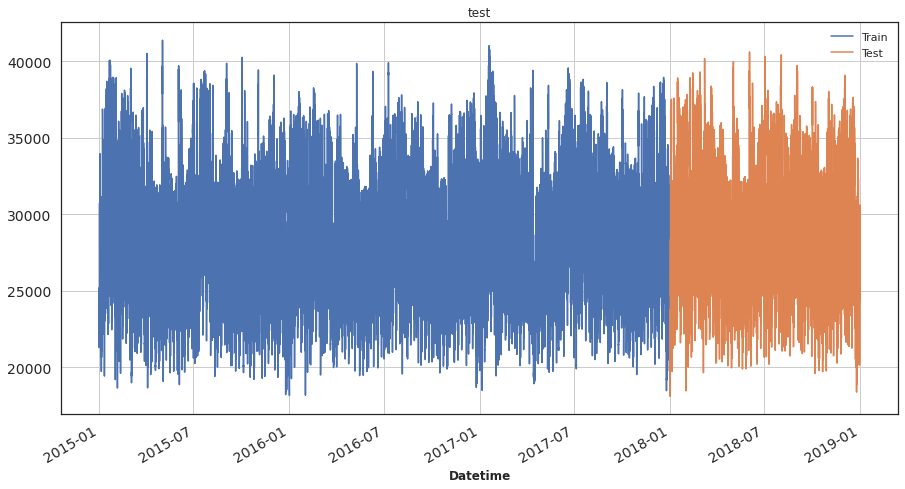

In [120]:
print('y Train Dataset:',train.shape)
print('y Test Dataset:',test.shape)
train['total load forecast'].plot(figsize=(15,8), title= 'train', fontsize=14, label='Train')
test['total load forecast'].plot(figsize=(15,8), title= 'test', fontsize=14, label='Test')
plt.legend()
plt.grid()
plt.show()

Start of Fit.....
    Target variable given as = total load forecast
Start of loading of data.....
    Inputs: ts_column = Date, sep = ,, target = ['total load forecast']
    Using given input: pandas dataframe...
    Date column exists in given train data...
    train data shape = (25747, 17)
Alert: Could not detect strf_time_format of Date. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is already stationary
There is no differencing needed in this datasets for VAR model
No time series plot since verbose = 0. Continuing
Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Nu

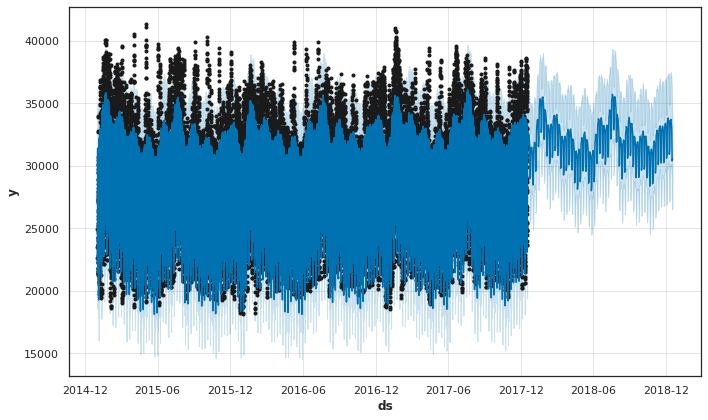

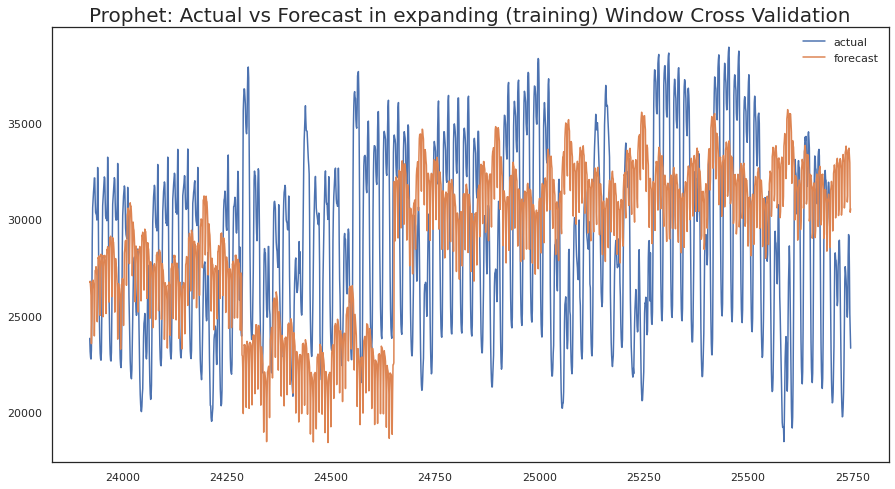

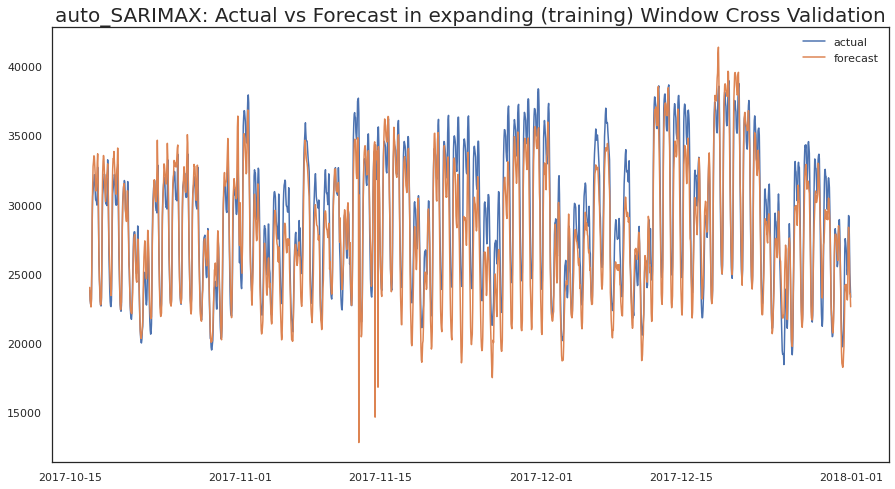

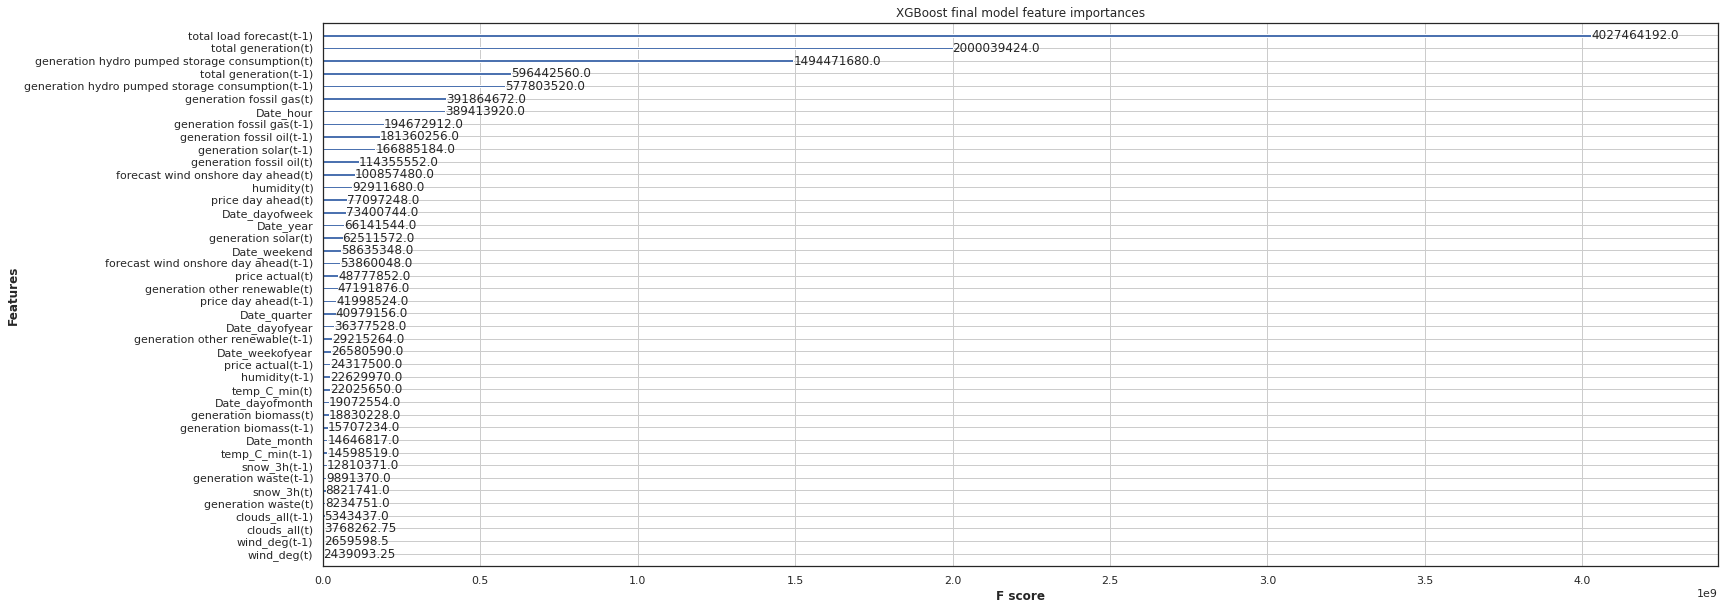

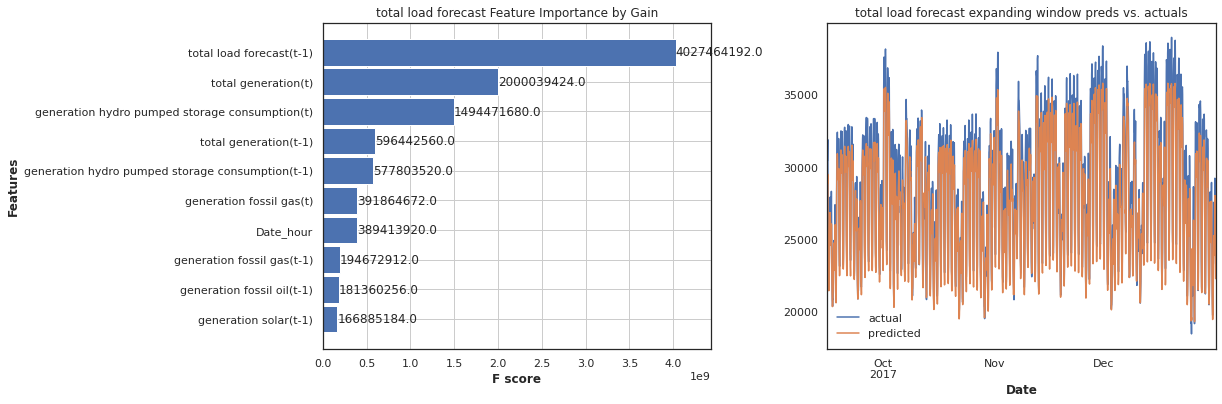

In [121]:
# Using Auto_ts to create a model and the predict from the best one and ensemble it
# Way too much output - needs a way to silence this.
 
model = auto_timeseries(forecast_period=365, score_type='rmse', 
                        time_interval='D', 
                        model_type='best', 
                        ensemble='all',
                        cv=5,
                        verbose=0
                       )
model.fit(traindata= train, ts_column='Date', target="total load forecast");


# Once the model is created and fit it is time to make some predictions. These are then stored in a dataframe for printing. The first graph below whos the predictions for the whole year and in general it can be seen that the predictions are below the actuals (blue vs orange). If I zoom in to the first 1000 records then a pattern starts to emerge in that the model has actually captured the shape of the double maxmima in load that occurs in the evening, though not the magnitude. 
# Finally the MAPE is calculated and dissapointingly it is still too high at 13.85%, however, by switching to using more paraameters for forecasting more detail has been captured. So lastly another multivariate method will be used an LSTM neural network.

In [122]:
# show the models performance
model.get_leaderboard()

name         rmse
2            ML  1329.418059
1  auto_SARIMAX  2049.522738
0       Prophet  6001.523337

In [123]:
predictions = model.predict(testdata=test, model='best')

Predicting using test dataframe shape = (8721, 18) for ML model
For large datasets: ML predictions will take time since it has to predict each row and use that for future predictions...
    Using given input: pandas dataframe...
    Alert: No strf_time_format given for Date. Provide strf_time format during "setup" for better results.
ML predictions completed


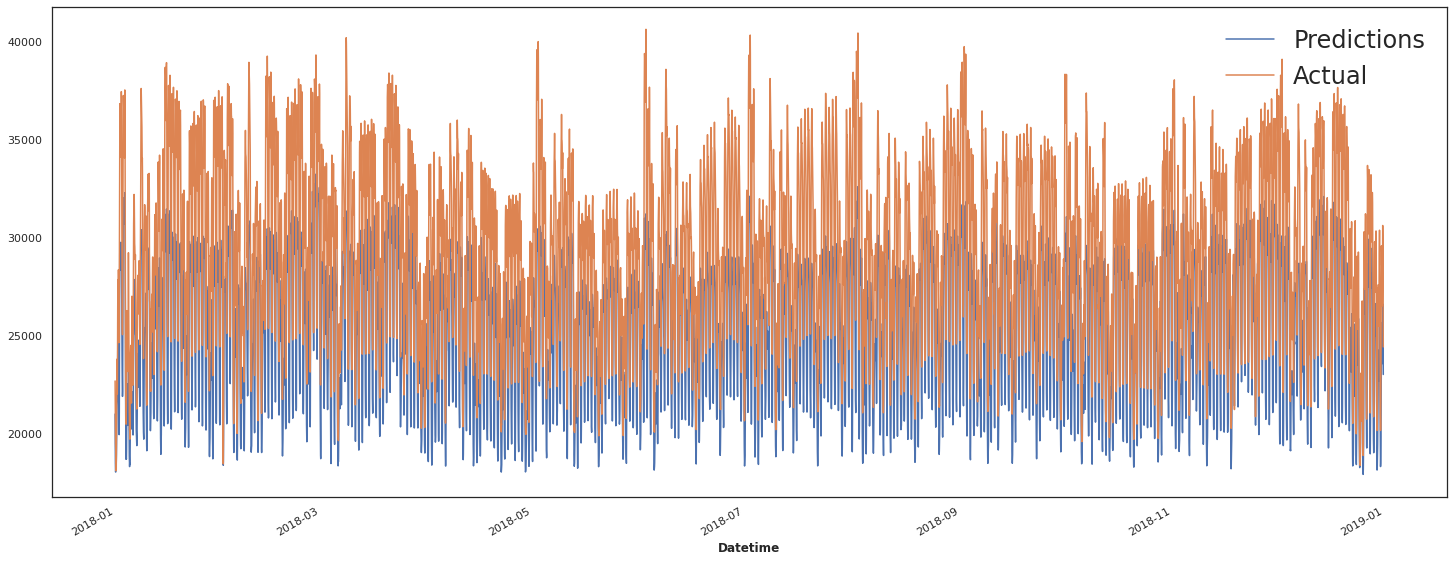

In [124]:
predictions['total load forecast'].plot(label='Predictions')
test['total load forecast'].plot(label='Actual')
plt.legend(fontsize=24)

# And now by zooming into the first 1000 values the prediction shows a similar shape to the actual values, correctly predicting the shape of the two daily peaks if not the correct magnitude.

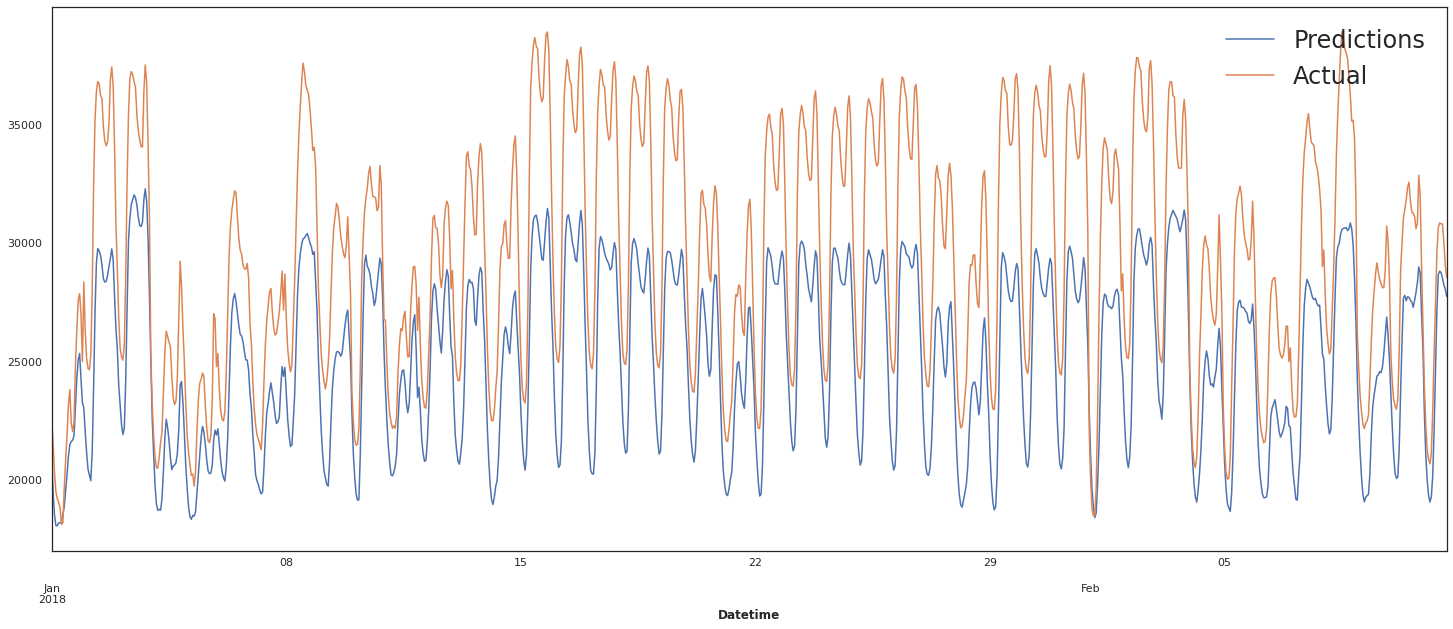

In [125]:
predictions['total load forecast'][0:1000].plot(label='Predictions')
test['total load forecast'][0:1000].plot(label='Actual')
plt.legend(fontsize=24)

In [126]:
print('The mean absolute percentage error = {:.2f}%'.format(mean_absolute_percentage_error(predictions['total load forecast'],test['total load forecast'])*100))

The mean absolute percentage error = 13.88%


# Create a scaler to get all data on the same scale. Create the training, validation and testing datasets and use the scaler on them. Then define a function to create the X and y data in the right shape for feeding into the LSTM and use on each of the datasets. As we are trying to forecast the day ahead usage there are 2 approaches that can be taken:
1. The first of which is to resample the dataset on a daily basis (resample("D")) - and dropna as 1 rows of nas introduced
2. Use the hourly data and forecast 24 hours into the future

In [127]:
df_daily = df_joined_pred.resample("D").mean().dropna()

## Next creatre train, val and test datasets from this daily data, then scale and define a function to create the right inputs for an LSTM model

In [128]:
# Create the train (2015/2016), val (2017), test datsets (2018) 
train_day, val_day, test_day = df_daily['2015-01-01':'2016-12-31'], df_daily['2017-01-01':'2017-12-31'], df_daily['2018-01-01':'2018-12-31']

In [129]:
train_day.columns

Index(['total load forecast', 'total generation', 'generation fossil gas',
       'generation fossil oil', 'price day ahead', 'price actual',
       'generation solar', 'temp_C_min', 'generation other renewable',
       'generation biomass', 'generation waste',
       'forecast wind onshore day ahead', 'clouds_all', 'snow_3h', 'wind_deg',
       'humidity', 'generation hydro pumped storage consumption'],
      dtype='object')

In [176]:
# Since on 3 years of data, best to ignore validation dataset and simply train based obn the first 3 years and test on the final year.
# Create the train (2015/2016), val (2017), test datsets (2108) 
train_day, test_day = df_daily['2015-01-01':'2017-12-31'], df_daily['2018-01-01':'2018-12-31']

In [191]:
# First need to normalise the df - scale all values between 0 and 1

scaler = MinMaxScaler(feature_range=(0,1))

train_day_scaled = scaler.fit_transform(train_day)
#val_day_scaled   = scaler.fit_transform(val_day)
test_day_scaled  = scaler.fit_transform(test_day) 

# finally create a scaler for the total load forecast column for easy  transform of the predictionss - y values - 
predict_day_scaler = MinMaxScaler(feature_range=(0,1))
y_test_day_scaled = predict_day_scaler.fit_transform(test_day[['total load forecast']])


In [209]:
# define a function to create X and y training sets from the scaled df_joined_pred dataset
# reshape input to be 3D [samples, timesteps, features]
def df_to_X_y(scaled_df, timesteps): 
    X, y = [], []
    for i in range(len(scaled_df)-timesteps): 
        row = [r for r in scaled_df[i:i+timesteps]] 
        X.append(row)
        label = scaled_df[i+timesteps][0] 
        y.append(label)
    return np.array(X), np.array(y)

In [210]:
# For the daily values - previous timesteps in days for forecasting next day.
# test for 30, 60, 90, 120, 150 and 180 days prior (i.e. 1,2,3,4,5 or 6 months early) - any more than that will leave too little to test on
days = 60

train_day_X, train_day_y = df_to_X_y(train_day_scaled, days)
#val_day_X, val_day_y     = df_to_X_y(val_day_scaled, days)
test_day_X, test_day_y   = df_to_X_y(test_day_scaled, days)

train_day_X.shape, train_day_y.shape, test_day_X.shape, test_day_y.shape  #val_day_X.shape, val_day_y.shape , 

((1035, 60, 17), (1035,), (305, 60, 17), (305,))

# Create the LSTM model, then fit and plot loss function with and early stopping feature is the val_loss is below 1 for more than 10 epochs. A table to multiple variations in the number of epochs and previous days are shown.

In [194]:
# create the LSTM model - the input of LSTM layer has a shape of (num_samples -- .shape[0], num_timesteps --.shape[1], num_features --.shape[2])
model = Sequential()
model.add(InputLayer((train_day_X.shape[1],train_day_X.shape[2]))) 
model.add(LSTM(64, input_shape=(train_day_X.shape[0], train_day_X.shape[2]), return_sequences=False))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                20992     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 21,521
Trainable params: 21,521
Non-trainable params: 0
_________________________________________________________________


Epoch 157: early stopping


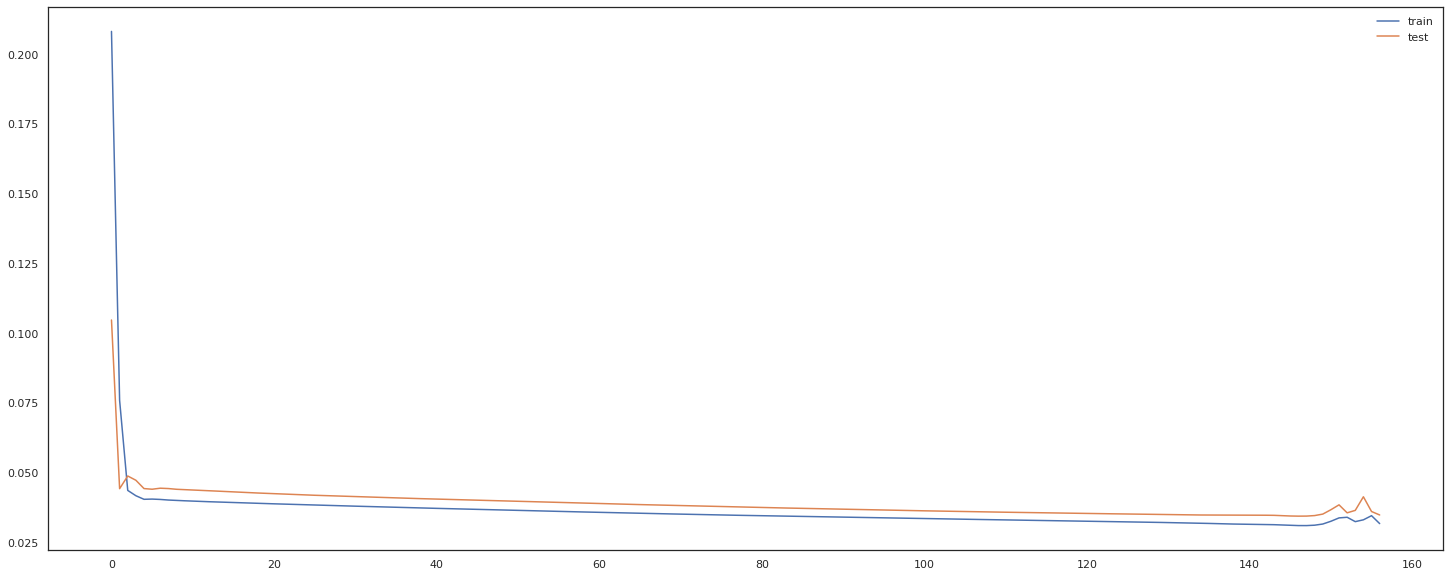

In [195]:
# Compile and run the model amd plot the loss function, num epochs set at 200 but early stopping means should not reach that
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
#  early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# fit network
history = model.fit(train_day_X, train_day_y, epochs=200, batch_size=72, validation_data=(test_day_X, test_day_y), verbose=0,shuffle=False, callbacks=[es]) #validation_data=(val_day_X, val_day_y)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Now use it to make a prediction. The dates are not shown on the plot just the number of days the forecast is for - essentially (365 - days) forecast values. Then have to reshape the predictions for unscaling and plotting into format (num samples, num timesteps, features per step)

In [197]:
predictions = model.predict(test_day_X)


In [198]:
#pred_1 = predict_day_scaler.inverse_transform(predictions)

#pred_df = pd.DataFrame(pred_1)
#frames = [test_day['total load forecast'],pred_df]
#pd.concat(frames )
#len(test_day['total load forecast'])


In [199]:
# but this will now only be one column
print(predictions.shape)
# Need to add columns to match original size used to scale data - so just add 16 columns of the predictions data to make it 17 columns long
prediction_copies_array = np.repeat(predictions,test_day_X.shape[2], axis=-1)
print(prediction_copies_array.shape)
# Now can use inverse scaler (transform)  as it is the same shape as used to scale - and only get the first column
pred = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(predictions),17)))[:,0]
pred[0:5]

(305, 1)
(305, 17)


array([29590.053, 29578.123, 30052.502, 29850.562, 29143.697],
      dtype=float32)

In [200]:
original_copies_array = np.repeat(test_day_y,17, axis=-1) 
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(test_day_y),17)))[:,0]
original.shape

(305,)

In [201]:
# store the orignial and predicted value in a dataframe
df_daily_final = pd.DataFrame(data={'Predictions':pred, 'Actuals':original })  

Text(0.5, 1.0, 'Predictions vs Actuals')

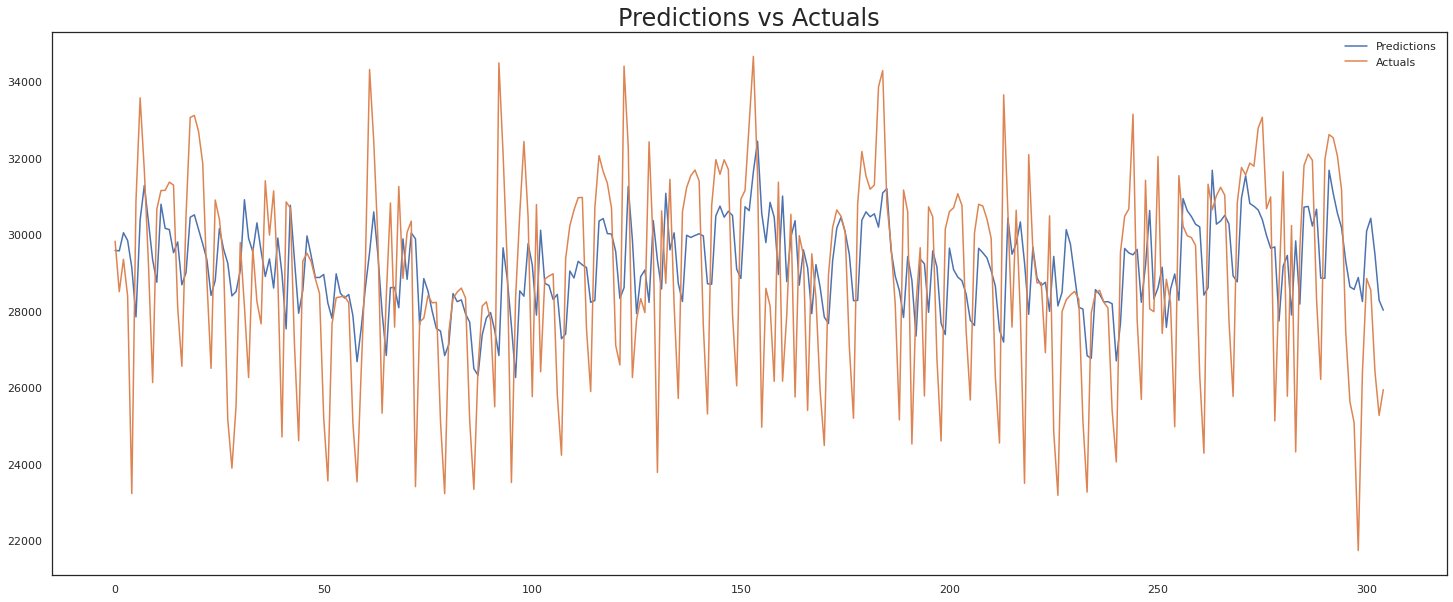

In [204]:
df_daily_final[100:200].plot()
plt.title("Predictions vs Actuals", fontsize =24)

In [203]:
print('The mean absolute percentage error  = {:.2f}%'.format(mean_absolute_percentage_error( df_daily_final['Actuals'],df_daily_final['Predictions'])*100))


The mean absolute percentage error  = 6.75%


# Tabulated below are the results of several test varying the number of days used as 'history' for running through the LSTM. 
## The initial run of 10 days and 10 epochs which gave a very large error. After that early stopping was set up inside the LSTM - once there isn't an improvement of 1% in mean square error in 10 epochs the model stops. The results are similar no matter how many days worth on input is used - a MAPE of between 6.75 and 8.07%

|Prior days of input|Epochs(early stopping)|MAPE %|
|---|---|---
|10|10|18.28|
|10|24|7.73
|30|92|7.05
|60|157|6.75
|90|82|7.83
|120|25|7.67
|150|16|8.07
|180|17|7.87

